# P3

This part of the ADA project is the presentation of a creative extension to the paper studied in the replication work. For us, the paper is “Signed Networks in Social Media”, written by Jure Leskovec, Daniel Huttenlocher, and Jon Kleinberg and published on the 10-15th of April 2010 at Atlan during the 2010 Conference on Human Factor in Computing System (CHI), USA, in the Machine Learning and Web Interaction chapter. 
The original paper can be found with this <a href = https://cs.stanford.edu/people/jure/pubs/triads-chi10.pdf>link</a>, and the three datasets, Epinion, Slashdot, and Wikipedia can also be found with this <a href = https://drive.google.com/drive/folders/1r_K-XMqu5OW9vieoqNgzOTw2GA1hVVzc>link</a>.. 

Because social networks are a huge scientific and political strike nowadays, the comprehension of its characteristics, sensibility, and behavior are very important. Most of the researches in signed networks has only considered ever positive or negative edges. Here they are using both. They compare two major social network theories: the balance and status ones. 
Few words about the dataset they use : 
- “trust network of Epinion”, then referred to as **Epinion**
- “Social network of technology blog Slashdot”, then referred to as **Slashdot**
- “Wikipedia votes for admin nomination”, then referred to as **Wikipedia**

Our creative extension idea will revolve around the following research question: *Are balance and status theory sufficient to investigate the structure of social networks, or are there other parameters that may have an impact?*


So in the first part, we will study the balance and status theory following the approach explained in the paper, but on a new dataset, called **Reddit**. Thus we will be able to identify more closely the strength and limits of these methods and thus put into perspective the conclusions drawn in the study and nuance them. In the second part, we will focus on the possible impact of two variables, Time and Weight, on network structure. To do so we will identify the trend of edge distribution according to these variables to then extract subgraphs and compute network structure parameters to quantitatively compare their organization.

Let's have a few words to present the new Reddit dataset. According to its Wikipedia page, it is an "*American social news aggregation, web content rating, and discussion website*. A community on this website is called a *SubReddit*. The new dataset is a hyperlink network between subreddits. A hyperlink is a word, phrase, or image that you can click on to jump to a new document, the subreddit-to-subreddit hyperlink network we are using here is drawn from the posts that create hyperlinks between two subreddits, from writer to the receiver. So each node is a subreddit and each edge corresponds to a post. Additionally, each link has so properties computed from its post content: the number of characters, the number of words but also the positive and negative sentiment score among other ones. Two datasets are presented here, one extracted from the text content of the posts ("body") and the second from the "title". 

For the first part of the analysis, it appears more relevant to use both altogether as a total dataset while for the second part we have chosen to focus on the body one, as we will use sentiment score for the weight the one computed from bigger content seems to be more relevant.

First we load some useful libraries.

In [1]:
import pandas as pd
import numpy as np
import networkx as nx

In [2]:
# ---------------------------------------- should comment
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Let's start with the first part, evaluation of balance and status theory using the new **Reddit** dataset. 

# Part 1
So here we aim to analyse Reddit dataset to identify strengths and limits of the balance and status theory.

## 1.1] Replicate Table 3 for the Reddit data
First of all, we have chosen to replicate the Table 3 of the paper, but for the Reddit dataset. This table is a summary of the triad type distribution in the graph. We knwo that replication is not a creative extension, however here our goal is to use the pipeline to assess balance and status theory built in the paper to another dataset, to experience it. In that way it will allow us maybe to nuance the conclusion of the study under the light of our own conclusions with Reddit dataset. 

The Table 3 contains the number of triangles of the 4 triads type : 
- T0 :  ---
- T1 :  --+
- T2 :  -++ 
- T3 :  +++

We are conscious that the replication of table 3 is the individual part of P3. Thus we didn't share our code, we imported our function to this notebook without given the code. Thus it appears here as a "black box", but we can still discuss the results in our ongoing analysis. 

### 1.1.1]Load the Reddit data and do some basic analysis
We begin with replication of table 3, to have an idea of the basic characteristics of the network. Here we compute it for the body, title and body-title Reddit dataset. 

**Load the data**

We define the path to the files, and then use `pd.read_csv` function to load the data. We use '\t' as the delimitator.

In [3]:
# definition of the path
DATAFOLDER = '/content/drive/MyDrive/ADA - dataset/'
reddit_data_body_file = DATAFOLDER + 'soc-redditHyperlinks-body.tsv'
reddit_data_title_file = DATAFOLDER + 'soc-redditHyperlinks-title.tsv'
wikipedia_file = DATAFOLDER + 'wikiElec.ElecBs3.txt'

# Reading of the files
data_body = pd.read_csv(reddit_data_body_file, sep = '\t')
data_title = pd.read_csv(reddit_data_title_file, sep = '\t')
data_body.head(2)

,SOURCE_SUBREDDIT,TARGET_SUBREDDIT,POST_ID,TIMESTAMP,LINK_SENTIMENT,PROPERTIES
0,leagueoflegends,teamredditteams,1u4nrps,2013-12-31 16:39:58,1,"345.0,298.0,0.75652173913,0.0173913043478,0.08..."
1,theredlion,soccer,1u4qkd,2013-12-31 18:18:37,-1,"101.0,98.0,0.742574257426,0.019801980198,0.049..."


We rename the sign column, to have consistency with datasets like wikipedia, slashdot, epinions

In [ ]:
data_body = data_body.rename(columns = {'LINK_SENTIMENT' : 'Sign'})
data_title = data_title.rename(columns = {'LINK_SENTIMENT' : 'Sign'})
data_body.head(10)

,SOURCE_SUBREDDIT,TARGET_SUBREDDIT,POST_ID,TIMESTAMP,Sign,PROPERTIES
0,leagueoflegends,teamredditteams,1u4nrps,2013-12-31 16:39:58,1,"345.0,298.0,0.75652173913,0.0173913043478,0.08..."
1,theredlion,soccer,1u4qkd,2013-12-31 18:18:37,-1,"101.0,98.0,0.742574257426,0.019801980198,0.049..."
2,inlandempire,bikela,1u4qlzs,2014-01-01 14:54:35,1,"85.0,85.0,0.752941176471,0.0235294117647,0.082..."
3,nfl,cfb,1u4sjvs,2013-12-31 17:37:55,1,"1124.0,949.0,0.772241992883,0.0017793594306,0...."
4,playmygame,gamedev,1u4w5ss,2014-01-01 02:51:13,1,"715.0,622.0,0.777622377622,0.00699300699301,0...."
5,dogemarket,dogecoin,1u4w7bs,2013-12-31 18:35:44,1,"1328.0,1110.0,0.768825301205,0.0143072289157,0..."
6,locationbot,legaladvice,1u4wfes,2014-01-07 20:17:41,1,"184.0,172.0,0.744565217391,0.0326086956522,0.0..."
7,indiefied,aww,1u50pos,2014-03-03 17:00:35,1,"295.0,256.0,0.749152542373,0.0203389830508,0.0..."
8,posthardcore,bestof2013,1u5ccus,2013-12-31 23:16:20,1,"3927.0,3488.0,0.719887955182,0.0229182582124,0..."
9,posthardcore,corejerk,1u5ccus,2013-12-31 23:16:20,1,"3927.0,3488.0,0.719887955182,0.0229182582124,0..."


**Create the dataframe containing body + title links**

As we said we want to compute this table for the body_title dataset as well. To do this we simply concatenate the dataframes `data_title` and `data_body`.

In [ ]:
data_total = pd.concat([data_body,data_title], ignore_index = True)
data_total.head()

,SOURCE_SUBREDDIT,TARGET_SUBREDDIT,POST_ID,TIMESTAMP,Sign,PROPERTIES
0,leagueoflegends,teamredditteams,1u4nrps,2013-12-31 16:39:58,1,"345.0,298.0,0.75652173913,0.0173913043478,0.08..."
1,theredlion,soccer,1u4qkd,2013-12-31 18:18:37,-1,"101.0,98.0,0.742574257426,0.019801980198,0.049..."
2,inlandempire,bikela,1u4qlzs,2014-01-01 14:54:35,1,"85.0,85.0,0.752941176471,0.0235294117647,0.082..."
3,nfl,cfb,1u4sjvs,2013-12-31 17:37:55,1,"1124.0,949.0,0.772241992883,0.0017793594306,0...."
4,playmygame,gamedev,1u4w5ss,2014-01-01 02:51:13,1,"715.0,622.0,0.777622377622,0.00699300699301,0...."


**Convert the names into ids**

Here, we use the `Dictionnary` from the `gensim` library, to create a dictionnary based on a list of strings. Then we use the `doc2idx` method to convert strings into integer ids.

In [ ]:
from gensim.corpora import Dictionary #import the library

#Create the list of strings : we add each subreddit from the unique values in the 
#SOURCE_SUBREDDIT and the TARGET_SUBREDDIT columns
unique_subreddits = [[element] for element in list(pd.concat([data_total['SOURCE_SUBREDDIT'], data_total['TARGET_SUBREDDIT']]).sort_values().unique())]
dct = Dictionary(unique_subreddits)

#we use doc2idx to convert strings into ids
data_total['FromNodeId'] = dct.doc2idx(data_total['SOURCE_SUBREDDIT'].values)
data_total['ToNodeId'] = dct.doc2idx(data_total['TARGET_SUBREDDIT'].values)

**Do we have the same edges several times ?**

Here we want to know if a node (a subreddit) can link to another node several times. We take the example of leagueoflegends and leagueoflegendsmeta, as there are related topics, we can expect they have many links

In [ ]:
test_lol = data_body[data_body['SOURCE_SUBREDDIT'] == 'leagueoflegends']
test_lol[test_lol['TARGET_SUBREDDIT'] == 'leagueoflegendsmeta']

,SOURCE_SUBREDDIT,TARGET_SUBREDDIT,POST_ID,TIMESTAMP,Sign,PROPERTIES
311,leagueoflegends,leagueoflegendsmeta,1ue5u4s,2014-01-04 07:15:08,1,"705.0,604.0,0.756028368794,0.00567375886525,0...."
27785,leagueoflegends,leagueoflegendsmeta,28luias,2014-06-19 20:03:26,1,"1763.0,1431.0,0.667612024957,0.0328984685196,0..."
78113,leagueoflegends,leagueoflegendsmeta,2ygs2ns,2015-03-09 12:18:40,1,"1963.0,1643.0,0.792154865003,0.00254712175242,..."
108915,leagueoflegends,leagueoflegendsmeta,3d3lkls,2015-07-13 00:32:14,1,"4002.0,3336.0,0.755872063968,0.0114942528736,0..."
136923,leagueoflegends,leagueoflegendsmeta,3qzyi1s,2015-10-31 20:19:30,1,"1809.0,1512.0,0.782752902156,0.00110558319514,..."


We see it's possible that a source subreddit has a hyperlink to a target subreddit several times.

**Count the number of nodes and edges**

To count the number of edges, we count the number of lines in the dataframe. To count the number of nodes, we count the number of unique values in the `SOURCE_SUBREDDIT` and `TARGET_SUBREDDIT` columns. We create the table that will contain the number of nodes, the number of edges and the proportion of poistive/negative edges.

In [ ]:
#Create the table
table = pd.DataFrame(columns = ['body', 'title', 'total'], index = ['Nodes', 'Edges', '+ edges', '- edges'])

nb_edges_body = data_body.shape[0]
nb_nodes_body = np.unique(np.concatenate((data_body['SOURCE_SUBREDDIT'].values , data_body['TARGET_SUBREDDIT'].values))).shape[0]

nb_edges_title = data_title.shape[0]
nb_nodes_title = np.unique(np.concatenate((data_title['SOURCE_SUBREDDIT'].values , data_title['TARGET_SUBREDDIT'].values))).shape[0]

nb_edges_total = data_total.shape[0]
nb_nodes_total = np.unique(np.concatenate((data_total['SOURCE_SUBREDDIT'].values , data_total['TARGET_SUBREDDIT'].values))).shape[0]


#Fill the table
table.loc['Nodes'] = [nb_nodes_body, nb_nodes_title, nb_nodes_total]
table.loc['Edges'] = [nb_edges_body, nb_edges_title, nb_edges_total]

table.head()

,body,title,total
Nodes,35776,54075,67180
Edges,286561,571927,858488
+ edges,NaN,NaN,NaN
- edges,NaN,NaN,NaN


**Count the proportion of positives and negative edges**

Here, for a given dataset, we count the number of posiive edges, then we compute its proportion.

In [ ]:
#Number of positive (negative) edges :
#We first filter the data by keeping only +1 (or -1) values and then we find the number of lines (edges) that this filtering gives
nb_pos_edges_body = data_body[data_body['Sign']==1].shape[0] 
nb_neg_edges_body = data_body[data_body['Sign']==-1].shape[0]

nb_pos_edges_title = data_title[data_title['Sign']==1].shape[0] 
nb_neg_edges_title= data_title[data_title['Sign']==-1].shape[0]

nb_pos_edges_total = data_total[data_total['Sign']==1].shape[0] 
nb_neg_edges_total = data_total[data_total['Sign']==-1].shape[0]

#Proportion of positive/negative edges:
#We divide the number of positive (or negative) edges previouly found and divide it by the total number of edges
#We use the table1 to find the total number of edges as we already filled these informations
perc_pos_body = nb_pos_edges_body / table.loc['Edges']['body']
perc_neg_body = nb_neg_edges_body / table.loc['Edges']['body']

perc_pos_title = nb_pos_edges_title / table.loc['Edges']['title']
perc_neg_title = nb_neg_edges_title / table.loc['Edges']['title']

perc_pos_total = nb_pos_edges_total / table.loc['Edges']['total']
perc_neg_total = nb_neg_edges_total / table.loc['Edges']['total']

In [ ]:
#We must indicate a percentage format : we use the {:.1%} format to have a percentage with only one decimal, as in the paper 
table.loc['+ edges'] = ['{:.1%}'.format(perc_pos_body), '{:.1%}'.format(perc_pos_title), '{:.1%}'.format(perc_pos_total)]
table.loc['- edges'] = ['{:.1%}'.format(perc_neg_body), '{:.1%}'.format(perc_neg_title), '{:.1%}'.format(perc_neg_total)]

table.head()

,body,title,total
Nodes,35776,54075,67180
Edges,286561,571927,858488
+ edges,92.6%,89.3%,90.4%
- edges,7.4%,10.7%,9.6%


So here is the final dataframe with the results regrouped.

**Analysis :** 
We can see that both body and title dataset have positive edge percentage around 90%, which is higher than the ones of the 3 original dataset Epinion, Slashdot and Wikipedia. Body and Title dataset have a total number of nodes higher than Wikipedia one and lower than Slashdot one. Thus it is at least in the same range as the study analysis, so it is ok. Finally the title dataset has the same magnitude order of edges than the Slashdot dataset, and the body one has a number of edges with Slashdot and Wikipedia one. So, as said before, it is in the same range as the study so it is ok.

In the following steps of this first part, we have chosen to use the total dataframe because it has more nodes and edges. We can see on the dataframe presented that it has a bit less node than the Slashdot dataset and as much edges than the epinion one. As it contains both edges drawn from body and title of the same posts, this dataset will have many multiple edges: several links from a same nodeA to a same nodeB. As for expected because of the body and title positive edge percentage, the total Reddit dataset also has a positive edge percentage of 90.4% which around 10% higher than the one of the 3 original ones Epinion, Slashdot and wikipedia. 

### 1.1.2] Replicate table 3
Now that we have preprocessed our data and have a better idea of their basic features, we can compute the table 3. To do so we first create the graph associtated to the total Reddit dataset using the `networkx` library.

**Create the graph with networkx**
As said before, because the replication of table 3 is part of the individual work we present it here as a "black box". If the reader needs more details, he can refers to the methods defined in Sinan's personal jupyter notebook.

In [ ]:
from table3 import create_table3

table3_reddit = create_table3(data_total, data_type = 'reddit')

So here is the resulting Table 3 for total reddit dataset. 

In [ ]:
table3_reddit.head()

,Triad Ti,|Ti|,p(Ti),p0(Ti),s(Ti)
0,T3 +++,1644323,0.863557,0.895420,-143.680338
1,T1 +--,41431,0.021759,0.009851,166.372390
2,T2 ++-,209148,0.109839,0.093704,76.401376
3,T1 ---,9225,0.004845,0.001024,164.806020


**Analysis :** The  principle of the table 3 is that one can compare the proportion of triads (per type Ti) p(Ti) (from the |Ti|, count of triads measurements) with the proportion of triads obtained with randomized edges and thus only based on positive and negative edges proportions, p0(Ti). So if p(Ti) < p0(Ti) than the triad Ti is under-expressed while if p(Ti) > p0t(Ti) the triad Ti is over-expressed. The parameter s(Ti) is called *the surprise* and corresponds to the *number of standard deviations by which the actual quantity of type-Ti triads differs from the expected number under the random-shuffling mode*, so a quantification of the differences between observed and random resutls. 

***
Reminder : the balance theory, also called Heider's theory, says that some triads, T3 (3 friends) and T1 (2 friends with a common ennemi) are more plausible than T2 (two ennemies with a common friend) and T0 (3 ennemies). The weak version of the theory, also called Davis's theory only says that T3 is more plausible than T2, but T1 and T0 have no reason to be preferred one over the other. 
***

As one can see on the dataframe shown, the triads T0, T1 and T2 are over-represented (p(Ti) < p0(Ti) while the triads T3is under-represented. The over-representation of T1 is in accordance with Heider's theory however the T3 is not supposed to be under-represented, and T2 and T0 are not supposed to have a such difference of proportion with the randomized one. 

As a reminder, for Epinion, Slashdot and Wikipedia dataset, the results were in according with the weak version of balance theory, the Davis's theory : T2 is heavily under-represented and T0 and T1 present the same s(Ti). 

It is not the case for the reddit dataset, here we have found an example where  the Davis's balance theory cannot explained the triads type distribution. Therefore the use of this new dataset help to see the weakeness of the conclusions done in the paper and the balance theory may not be able to explaine edges in a undirected triad. In fact, the conclusion on the consistency of the balance theory seems to be dataset-dependant.

## 1.2] Study of reciprocated links

Now that we have an idea about how balance theroy explains the edges in reddit undirected triads, we want to assess the consistency of status theory.

This part consist in replicating table 4 for the reddit data to enforce or refute the conclusion the authors do about reciprocated edges : balance theory is good to predict the sign of the reciprocated link of a positive link, and status explains well the sign of the reciprocated link of a negative link. 

We first replicate the table 4 for the wikipedia dataset to prove that our process is correct, and to ensure the reproducibility of this part of the paper. Again, we now that replication is not creative. However, as we have seen in the previous analysis part, our work seems to bring new lights on the paper's conclusions, thus it adds something to the study. 

### 1.2.1] Reciprocation of table 4 for the wikipedia dataset

**Load the wikipedia data and remove its neutral links**

We use the parsed file we created in P2.

In [ ]:
wiki_data = pd.read_csv(DATAFOLDER + 'wiki_parsed.txt', sep = '\t', header = None) #we load the data
wiki = wiki_data.rename(columns={0: "FromNodeId", 1 : "ToNodeId", 2 : "Sign"}) #renamethe columns
neutral_indx = wiki[wiki.Sign==0].index.values #We filter the dataset to keep neutral links and find the values of the indexes
wiki = wiki.drop(neutral_indx) #We drop these lines

**Create a dataframe that contains only reciprocated edges**

Notation : if A links towards B, we name A as the starting node, and B as the target node.<br>
Let A links towards B, a simple description of our strategy  to find if B links to A is to find all edges that have B as a starting node. If A is a part of the target nodes of B, then B links to A. We create a dataframe for which we only include reciprocated edges, we add both the edges from A to B, and from B to A.

The detailed code strategy to find reciprocated edges is : 
- Initialization : create a dataframe that will contain the edges for which we have a reciprocation.
- 1st loop : we loop over all starting nodes, namely we loop over each `from_node`. For each `from_node`, we filter the original dataset to only have edges that have `from_node` as starting node.
- 2nd loop : we loop over each target node of `from_node`. For each of these `to_node`, we filter the dataset to have edges that starts from `to_node`.
- Test assignement : if `from_node` is a part of the target node of `to_node`, then we add the edges. Sometimes there is the same edge several times : we have $A \rightarrow B$ several times. We decide to only have each edge one time : we just include $A \rightarrow B$ one time and $B \rightarrow A$ one time.

In [ ]:
#Initialization
wiki_reci = pd.DataFrame()

#1st loop : #for all starting nodes
for from_node in wiki['FromNodeId'].unique(): 
    #filter the dataset to have only the edges that have from_node as a starting node
    from_df = wiki[wiki['FromNodeId'] == from_node]
    
    #2nd loop : for each target node for 'from_node', the starting node 
    for to_node in from_df['ToNodeId'].values : 
        #filter the dataset to have the edges that have as starting node, the target node of 'from_node'
        to_df = wiki[wiki['FromNodeId'] == to_node] 
        
        if from_node in to_df['ToNodeId'].values: #
            #we add both edges
            wiki_reci = pd.concat([wiki_reci, wiki.loc[(wiki['FromNodeId'] ==from_node) & (wiki['ToNodeId']==to_node)].head(1)])
            wiki_reci = pd.concat([wiki_reci, wiki.loc[(wiki['FromNodeId'] == to_node) & (wiki['ToNodeId']==from_node)].head(1)])
            #we need to drop at least one edge from the original data to not add the reciprocation several times
            wiki = wiki.drop(wiki.loc[(wiki['FromNodeId'] ==from_node) & (wiki['ToNodeId']==to_node)].index)
            wiki = wiki.drop(wiki.loc[(wiki['FromNodeId'] ==to_node) & (wiki['ToNodeId']==from_node)].index)
            
wiki_reci.head() #2min30

,FromNodeId,ToNodeId,Sign
33,3,54,1
1157,54,3,1
720,3,28,1
1180,28,3,1
2144,3,178,1


In [ ]:
wiki_reci.shape[0]

We first want to know what part of the original wikipedia reciprocated edges represent. The authors say that about 3-5% of the original dataset's edges are reciprocation of existing links. 

To check this, we divide the number of edges of this dataframe containing reciprocated edges by two time the number of edges in the original dataset (because we counted the link and its reciprocation, while in the paper they only count the reciprocation).

In [ ]:
#we compute the proportion
print('propotion of reciprocated edges : {:.2%}'.format(wiki_reci.shape[0]/(2*wiki.shape[0])))

propotion of reciprocated edges : 2.96%


It seems we have a similar result than with the paper. Now we replicate table 4

**Replication of table 4 for the wikipedia dataset**

To do this, we first create the networkx graph associated with this dataframe. Then we replicate table 4. The idea to find the `P(+|+)` and `P(-|+)` is the following : for each node, we find each of its neighbors linked with a positive sign to it, and then we test what is the sign of the reciprocated link, and add a count to the corresponding field.

In [ ]:
from table4 import create_table4

table4_wiki = create_table4(wiki_reci, name_data = 'wikipedia')
table4_wiki.head()

,wikipedia,Count,Fraction
0,P(+|+),2542,0.950636
1,P(-|+),132,0.049364
2,P(+|-),206,0.662379
3,P(-|-),105,0.337621


Here is the table 4 from the paper :
>![image.png](attachment:efcb5830-fd78-4266-b9b0-a7c11f80fc6a.png)

Our results are not the exact same, but are very close to the ones in the paper. We compute the difference in term of percentage of expected value to quantify this difference : 
- T0 : 0.59%
- T1 : 10.24%
- T2: 12.84%
- T3 : 14.83%
So here we see that the percentage error are acceptable (<15%). We conclude on a good replication power of the paper for this table. We use the same process for the reddit data.

### 1.2.2] Replication of table 4 for the reddit dataset

We basically copy the functions from before, but with the reddit data.

**Create a dataframe that contains only reciprocated edges**

We use the exact same code as before, but his time we use the reddit dataset.

In [ ]:
reddit = data_total

reddit_reci = pd.DataFrame()
for from_node in reddit['FromNodeId'].unique(): #for all unique nodes
    #filter the dataset to have only the edges that have from_node as a starting node
    from_df = reddit[reddit['FromNodeId'] == from_node]
    for to_node in from_df['ToNodeId'].values : #for all target node of 'from_node'
        to_df = reddit[reddit['FromNodeId'] == to_node]
        if from_node in to_df['ToNodeId'].values:
            #we add both edges
            reddit_reci = pd.concat([reddit_reci, reddit.loc[(reddit['FromNodeId'] ==from_node) & (reddit['ToNodeId']==to_node)].head(1)])
            reddit_reci = pd.concat([reddit_reci, reddit.loc[(reddit['FromNodeId'] == to_node) & (reddit['ToNodeId']==from_node)].head(1)])
            #we need to drop at least one edge from the original data to not add the reciprocation several times
            reddit = reddit.drop(reddit.loc[(reddit['FromNodeId'] ==from_node) & (reddit['ToNodeId']==to_node)].index)
            reddit = reddit.drop(reddit.loc[(reddit['FromNodeId'] ==to_node) & (reddit['ToNodeId']==from_node)].index)
            
reddit_reci.head() 

,SOURCE_SUBREDDIT,TARGET_SUBREDDIT,POST_ID,TIMESTAMP,Sign,PROPERTIES,FromNodeId,ToNodeId
0,leagueoflegends,teamredditteams,1u4nrps,2013-12-31 16:39:58,1,"345.0,298.0,0.75652173913,0.0173913043478,0.08...",32023,57105
6172,teamredditteams,leagueoflegends,1xoxyes,2014-02-11 23:07:12,1,"288.0,252.0,0.774305555556,0.00694444444444,0....",57105,32023
311,leagueoflegends,leagueoflegendsmeta,1ue5u4s,2014-01-04 07:15:08,1,"705.0,604.0,0.756028368794,0.00567375886525,0....",32023,32026
4196,leagueoflegendsmeta,leagueoflegends,1wl2hzs,2014-01-30 12:32:16,1,"1117.0,928.0,0.761862130707,0.000895255147717,...",32026,32023
320,leagueoflegends,iama,1ueax1s,2014-01-04 08:32:51,1,"110.0,110.0,0.763636363636,0.0363636363636,0.0...",32023,27319


This operation took a very long time (hours), so i save it into a csv file to not running it again if needed.

In [ ]:
#save it into a csv file
reddit_reci.to_csv('reddit_reciprocation.csv')

In [ ]:
#If we saved the csv file, we can load it :
reddit_reci = pd.read_csv('reddit_reciprocation.csv')

In [ ]:
#we compute the proportion
print('propotion of reciprocated edges : {:.2%}'.format(reddit_reci.shape[0]/(2*reddit.shape[0])))

propotion of reciprocated edges : 5.38%


The proportion of the original dataset to be reciprocated edges is higher than for the wikipedia dataset.

**Replication of table 4**

In [ ]:
from table4 import create_table4

table4_reddit = create_table4(reddit_reci, name_data = 'reddit')
table4_reddit.head()

,reddit,Count,Fraction
0,P(+|+),27002,0.954505
1,P(-|+),1287,0.045495
2,P(+|-),1482,0.878483
3,P(-|-),205,0.121517


**Analysis :**
One can see that globally the fraction values of table 4 for Reddit have the same magnitude order as the results from Wikipedia dataset. Thus these results seems to be consistent with the conclusion authors make : if A-B is positive, we have in 95.4% of cases that B-A is positive as well, which is higher than the 90% of positive links in the data (original positive edge proportion). So balance theory explains well the proportion of $P(+|+)$, as a reciprocation of a positive link should be positive as well. 


The situation where A-B is negative have different output according to the theories : the balance one predicts a negative edge for B-A, while the negative one predict a positive edge. Here one can see that the if A-B is negative, B-A is positive in 87.8% of cases, which is (a bit) lower than the 90% of positive edges. 



Therefore we may say that status theory explains well the high proportion of $P(+|-)$, as if A links negatively to B (A thinks B has a ower status), then B should link positively to A (B thinks A has a higher status). 

 

**By curiosity, we can see several examples of links that satisfies $P(-|+)$, $P(+|-)$ and $P(-|-)$**

In [ ]:
#Examples of links satisfying P(-|+)
from table4 import print_p2

print_p2(reddit_reci, name_data = 'reddit', nb_ex = 10)

Examples of subreddits (A,B) satisfying P(-|+) : A link positive to B, B link negative to A 
example 1 :
A : leagueoflegends
B : gaming

example 2 :
A : leagueoflegends
B : leagueofmemes

example 3 :
A : nfl
B : chibears

example 4 :
A : nfl
B : detroitlions

example 5 :
A : nfl
B : steelers

example 6 :
A : nfl
B : showerthoughts

example 7 :
A : dogemarket
B : dogecoinscamwatch

example 8 :
A : metalcore
B : music

example 9 :
A : suicidewatch
B : needadvice

example 10 :
A : suicidewatch
B : mensrights



In [ ]:
#Examples of links satisfying P(+|-)
from table4 import print_p3

print_p3(reddit_reci, name_data = 'reddit', nb_ex = 4)

Examples of subreddits (A,B) satisfying P(+|-) : A link negative to B, B link positive to A 
example 1 :
A : leagueoflegends
B : cringepics

example 2 :
A : leagueoflegends
B : gameofthrones

example 3 :
A : leagueoflegends
B : todayilearned

example 4 :
A : leagueoflegends
B : caitlynmains



In [ ]:
#Examples of links satisfying P(-|-)
from table4 import print_p4

print_p4(reddit_reci, name_data = 'reddit', nb_ex = 4)

Examples of subreddits (A,B) satisfying P(-|-) : A link negative to B, B link positive to A 
example 1 :
A : leagueoflegends
B : bestof

example 2 :
A : leagueoflegends
B : dotamasterrace

example 3 :
A : suicidewatch
B : bestof

example 4 :
A : circlebroke
B : shitredditsays



## Conclusion of the first part 


We conclude that in a triad configuration, we can't assure that the balance theory can explain the sign of some links, because the study of the Reddit dataset gave results that are opposed to the balance theory : 
- only T1 overrepresented, but T3 underrepresented
- T1 > T2 which is good appart from the fact that T2 should'nt be over represented
--> with T3 under and T1>T2 don't follow the observations of the paper about consistency of Davis's theory

Furthermore, when we have reciprocated edges, balance theory is good to predict the sign of the reciprocation of a positive link. Whereas status theory is good to predict the sign of the reciprocation of a negative link. 



Then we study new variables and how they may impact the network structure through calculations of centrality, clustering and behavior parameters. We begin with the time. 

# Part 2

So here the idea is to **identify variables that are not taken into account in the status and balance theory** but which **may have an impact on the network structure**. It could help us to identify the strength and limits of these social theories, and thus define better their range of applications.
During the first part of this paper analysis, which is the replication of the results, we ignore some information about the dataset we used. **Time** is the major parameter we didn’t take into account during structure network analysis, so here we’ll try to see if in fact it may have an impact on it. It is our first variable. We will also consider a second variable, the **weight** of the edges. 


The aim of the overall process is to assess the importance or not of the new variable in network structure.
All along the analysis, we first start with the reddit dataset, and then with the wikipedia dataset used in the paper. 

**NOTE FOR PART 2** : On the following analysis we will only consider only the **body dataset** from reddit. As we will use sentiment score (positve and negative), it seams more relevant to use the one computed from a text than from a single title as it will be more nuanced and thus will represent better the overall idea of the post. Also as title and body are generating the same edge, we would have the same networks two time. For technical facilities and because we think that due to this similarity the two netwokrs would drive the same conclusions, we prefer to selection only one. 

The processus is the following: 
- work with the **REDDIT** dataset : 
1) First we identify the global trend in edges distribution according to the variable  
>- step 0 : work with Date data
>- step 1 : analysis of the year 
>- step 2 : analysis of the month 
>- step 3 : analysis of the day of the month and of the week 
>- step 4 : analyis of the hour 

Aim : identify the main trends among the time data, and thus define new subgraphs

2) Do the structural analysis of these subgraphs

Parameters : Centrality (degree, closeness, local clustering coefficient, centrality degree), Clustering (global), Behavior (Assortativity)

3) Discussion, First conclusion 

- work on the **Wikipedia** dataset:
4) Identification of global trends in edges distribution
>- same steps 0, 1, 2, 3, 4
Aim : same

5) Do the structural analysis of these second subgraphs 
>Parameters : Same

6) Discussion, Second Conclusion

- Put into perspective through a scheme situation
>- Draw the scheme of a situation, to illustrate how the time can influence the formation of new edges compared to status and balance theory. (Abstract, with a drawing).


## 2.1] Time analysis

We will apply this processus first on the Reddit dataset, and then on the wikipedia dataset, the only original one provided with the timestamp of the edge.

Let's start with the identification of the global trend.

## 2.1.1] Work on the Reddit dataset
### 2.1.1.1] Analyzing the global trend 
### **Step 0**  : Work with datetime data

#### Transform string date data into datetime ones

First we have to deal with the data representing the time. Here we print an example of how it looks like.

In [ ]:
print('Exemple : the date of the first post of the dataset is : {}'.format(data_body['TIMESTAMP'][3]))
print(' Its type is ',type(data_body['TIMESTAMP'][3]))

Exemple : the date of the first post of the dataset is : 2013-12-31 17:37:55
 Its type is  <class 'str'>


Here the date are strings, so we need to convert them into datetime form as we want to do time manipulation (e.g. year example). 

In [ ]:
# Useful libraries 
from datetime import datetime, date, time
import calendar 

Then we transform the string dates into*datetime* type using the `to_datetime` function with the format year-month-day and hour-minute-second.

In [ ]:
data_body['TIMESTAMP'] = pd.to_datetime(data_body['TIMESTAMP'], format='%Y-%m-%d %H:%M:%S', errors='coerce')

In [ ]:
data_body.head()

,SOURCE_SUBREDDIT,TARGET_SUBREDDIT,POST_ID,TIMESTAMP,Sign,PROPERTIES
0,leagueoflegends,teamredditteams,1u4nrps,2013-12-31 16:39:58,1,"345.0,298.0,0.75652173913,0.0173913043478,0.08..."
1,theredlion,soccer,1u4qkd,2013-12-31 18:18:37,-1,"101.0,98.0,0.742574257426,0.019801980198,0.049..."
2,inlandempire,bikela,1u4qlzs,2014-01-01 14:54:35,1,"85.0,85.0,0.752941176471,0.0235294117647,0.082..."
3,nfl,cfb,1u4sjvs,2013-12-31 17:37:55,1,"1124.0,949.0,0.772241992883,0.0017793594306,0...."
4,playmygame,gamedev,1u4w5ss,2014-01-01 02:51:13,1,"715.0,622.0,0.777622377622,0.00699300699301,0...."


Here are presented the first 5 lines of the Reddit dataset, with the time data in the *datetime* type. Graphically, normally no one can see the difference.

In [ ]:
print(type(data_body['TIMESTAMP'][0]))

<class 'pandas._libs.tslibs.timestamps.Timestamp'>


However, when checking againt the type of the "TIMESTAMP" data, we can see that now it is Timestamp, thus the conversion worked.

**Split the dataset into positive and negative edges**

Because we want to compute the ratio of negative versus positive edges to identify the global trends, we need to first split the dataset according to the sign of the edge.

*Positive*

We first filter the body dataframe to have only positive edges.

In [ ]:
body_pos = data_body.copy()
body_pos = body_pos.drop(body_pos[body_pos.Sign == -1.0].index).reset_index(drop=True) #we drop all negative edges

#size of the new dataframe
print('data body original .{}'.format(data_body.shape))
print('body POS {}'.format(body_pos.shape))

data body original .(286561, 6)
body POS (265491, 6)


Let's check we only have positive edges in `body_pos`

In [ ]:
print('Unique values in body_pos : {} '.format(body_pos['Sign'].unique()))

Unique values in body_pos : [1] 


We see we just have positive values.

In [ ]:
body_pos.head()

,SOURCE_SUBREDDIT,TARGET_SUBREDDIT,POST_ID,TIMESTAMP,Sign,PROPERTIES
0,leagueoflegends,teamredditteams,1u4nrps,2013-12-31 16:39:58,1,"345.0,298.0,0.75652173913,0.0173913043478,0.08..."
1,inlandempire,bikela,1u4qlzs,2014-01-01 14:54:35,1,"85.0,85.0,0.752941176471,0.0235294117647,0.082..."
2,nfl,cfb,1u4sjvs,2013-12-31 17:37:55,1,"1124.0,949.0,0.772241992883,0.0017793594306,0...."
3,playmygame,gamedev,1u4w5ss,2014-01-01 02:51:13,1,"715.0,622.0,0.777622377622,0.00699300699301,0...."
4,dogemarket,dogecoin,1u4w7bs,2013-12-31 18:35:44,1,"1328.0,1110.0,0.768825301205,0.0143072289157,0..."


*Negative*

We do the same but with negative edges

In [ ]:
body_neg = data_body.copy()
body_neg= body_neg.drop(body_neg[body_neg.Sign == 1.0].index).reset_index(drop=True)

#size of the new dataframe
print('data body original .{}'.format(data_body.shape))
print('body NEG {}'.format(body_neg.shape))

data body original .(286561, 6)
body NEG (21070, 6)


In [ ]:
print('In data body : sign of post 4 = ', data_body.iloc[0][4])
print('In body pos : sign of post 4 = ', body_neg.iloc[0][4])

In data body : sign of post 4 =  1
In body pos : sign of post 4 =  -1


Here we check if the sign associated to the post 4 and know to be initially positive is still present in the new negative dataset. In fact it is not, so the filtering worked. 

In [ ]:
print('Unique values in body_neg : {} '.format(body_neg['Sign'].unique()))

Unique values in body_neg : [-1] 


We can aslo use the `unique` function to checl the quality of filtering. Here we can see it worked. 

In [ ]:
body_neg.head()

,SOURCE_SUBREDDIT,TARGET_SUBREDDIT,POST_ID,TIMESTAMP,Sign,PROPERTIES
0,theredlion,soccer,1u4qkd,2013-12-31 18:18:37,-1,"101.0,98.0,0.742574257426,0.019801980198,0.049..."
1,karmaconspiracy,funny,1u6fz3,2014-01-01 12:44:19,-1,"186.0,182.0,0.741935483871,0.0376344086022,0.0..."
2,badkarma,gamesell,1u6t4g,2014-01-01 16:42:14,-1,"262.0,258.0,0.725190839695,0.0381679389313,0.0..."
3,casualiama,teenagers,1u70s8,2014-01-01 17:09:46,-1,"91.0,91.0,0.78021978022,0.032967032967,0.04395..."
4,australia,sydney,1u71zd,2014-01-01 17:24:46,-1,"2547.0,2158.0,0.801334903808,0.0051040439733,0..."


So now we have two datasets from the body Reddit original one, with respectively only the positive and only the negative edges.

### Step 1 : Analysis of the year

Let's have a look on the global trend identified for the year. 

In [ ]:
# load useful libraries for grafique representation of the results
import matplotlib.pyplot as plt

In [ ]:
# verify the type of data time 
print(type(data_body.TIMESTAMP [0]))
print(type(body_pos.TIMESTAMP [0]))

<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>


We verify the type of the "*TIMESTAMP*" data, it is Timestamp so we will be able to do time manipulation, such as year extraction. Then we print the number of posts associated to the year. To do so we use the function `groupby` applied on the "*TIMESTAMP*" field of the dataset, after year extraction, than we take the size of the subgroups computed using the `size()` function. 

In [ ]:
# Just to have an idea of what it'll look like. 
year_positive = body_pos.groupby(data_body['TIMESTAMP'].dt.year).size()
year_negative = body_neg.groupby(data_body['TIMESTAMP'].dt.year).size()

print('Year Positive', year_positive)
print('Year Negative', year_negative)

Year Positive TIMESTAMP
2013        7
2014    63342
2015    88572
2016    98167
2017    15403
dtype: int64
Year Negative TIMESTAMP
2013        7
2014    21038
2015       20
2016        4
2017        1
dtype: int64


Because differences seem to be huge between the positive and negative edges, we also compute the log version of the positve edges, to be able to grafically represent them on the same graph.

In [ ]:
np.log(body_pos.groupby(data_body['TIMESTAMP'].dt.year).size())

TIMESTAMP
2013     1.945910
2014    11.056304
2015    11.391571
2016    11.494425
2017     9.642318
dtype: float64

So here we can see on the 2 dataset that there are 5 years presented in the dataset : 2013, 2014, 2015, 2016 and 2017. Now we grafically represent the distribution of the edges according to the year. To do so we create two list containing the size of the subgroups computed with `groupby` on the year extracted from '*TIMESTAMP* data, for positive and negative dataset. The x-axis represent the year. 

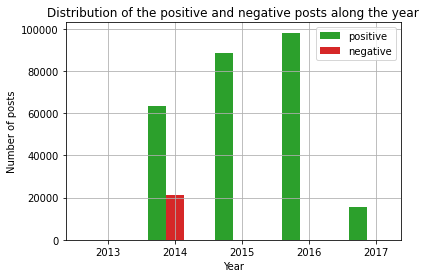

In [ ]:
# Grafical representation of the edges (+, -) distribution according to the year 
N = 5 #number of years presented : 2013, - 14, - 15, - 16 and - 17
ind = np.arange(N)  # the x locations for the groups
width = 0.27       # the width of the bars

fig = plt.figure()
ax = fig.add_subplot(111)
ax.grid()
 
year_pos = body_pos.groupby(data_body['TIMESTAMP'].dt.year).size()
rects1 = ax.bar(ind, year_pos, width, color='tab:green')

year_neg = body_neg.groupby(data_body['TIMESTAMP'].dt.year).size()

rects2 = ax.bar(ind+width, year_neg, width, color='tab:red')

ax.set_ylabel('Number of posts')
ax.set_xlabel('Year')
ax.set_title('Distribution of the positive and negative posts along the year')
ax.set_xticks(ind+width)
ax.set_xticklabels( ('2013', '2014', '2015', '2016', '2017') )
ax.legend( (rects1[0], rects2[0]), ('positive', 'negative') )

plt.show()

So has expected from the raw results values, the difference between the amount of positive and negative edges is very important and thus sometimes cannot appear on the same graph due to the scale. Thus we plot the log scale one to be able to compare them. 

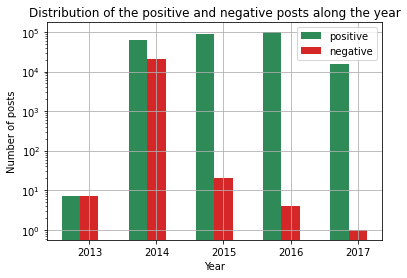

In [ ]:
# Grafical representation of the edges (+, -) distribution according to the year 
#log scale
N = 5
ind = np.arange(N)  # the x locations for the groups
width = 0.27       # the width of the bars

fig = plt.figure()
ax = fig.add_subplot(111)
ax.grid()
 
year_pos = body_pos.groupby(data_body['TIMESTAMP'].dt.year).size()
rects1 = ax.bar(ind, year_pos, width, color='seagreen')
plt.yscale('log')
year_neg = body_neg.groupby(data_body['TIMESTAMP'].dt.year).size()

rects2 = ax.bar(ind+width, year_neg, width, color='tab:red')

ax.set_ylabel('Number of posts')
ax.set_xlabel('Year')
ax.set_title('Distribution of the positive and negative posts along the year')
ax.set_xticks(ind+width)
ax.set_xticklabels( ('2013', '2014', '2015', '2016', '2017') )
ax.legend( (rects1[0], rects2[0]), ('positive', 'negative') )

plt.show()

**Analysis :**

- One can see that the year 2013 present the same number of positive and negative edges. However as it was inexistant on the previous graph it means that the total number of edges for 2013 is very small. In fact, looking at the raw result values, there are 7 positive and 7 negative edges for this year. These number are two small to do a network analysis on it, so we won't take them into account. These numbers are suprising between Reddit website have been create in 2005, so in 2013 it was already 8 years that it was on the internet. However, it still may have small popularity at that time. 
- Also using the raw results value we can see that the amount of negative edges for 2015, 2016 and 2017 is also very small and that can explain we cannot see the associated bars on the first graph. 
- One can see that the year 2014 - 2015 and 2016 present an interesting trend : the number of positive edges is raising while the number of negative ones is falling. Thus the ratio negative/positve might be very different, specially between the extreme. 
- The brutal decrease in 2017 in the amount of positive edges may be due to a sudden loss of popularity

One hypothesis to try to explain the huge differences in the amount of negative nodes might be external event influencing people's behavior. However we would need deeper social and historical analysis to draw an explanation. Neverless here we do not focus on the reason why do we observe such trends but how such trends can impact the network structure.

We then compute the ratio graph to be able to define the subgraphs representative of the trend with the following formula : 

$\text{ratio} = \frac{number of negative edges}{number of positive edges}*1000$

To represent it graphically we first define a list containing the ratio associated to each year. Then we create bar graphs with year on the x-axis. As the ratio is used in percentage %, it can goes from 0% (no negative edges) to 100% (same amount of positive and negative edges).

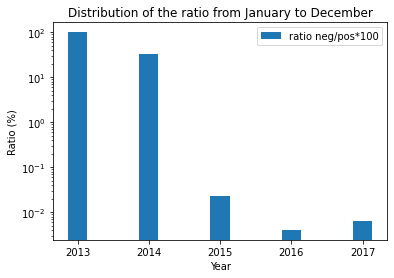

In [ ]:
# Grafical representation of the the ratio of edges (-/+*100) distribution according to the year 

ratio = [(int(b) / int(m))*100 for b,m in zip(year_neg, year_pos)]
N = 5
ind = np.arange(N)  # the x locations for the groups
width = 0.27       # the width of the bars

fig = plt.figure()
ax = fig.add_subplot(111)


rects1 = ax.bar(ind, ratio, width, color='tab:blue', label = 'ratio neg/pos*100')
plt.yscale('log')
ax.set_ylabel('Ratio (%)')
ax.set_xlabel('Year')
ax.set_title('Distribution of the ratio from January to December')
ax.set_xticks(ind)
ax.set_xticklabels( ('2013', '2014', '2015', '2016', '2017'))
plt.legend()

plt.show()

**Analysis :**

- So here we see 3 parts : 2013 (lot of negative votes), 2014 (almost 40%) and 2015-2016-2017 (very small amount of negative votes).
- As we are doing this in order to compare the structure of the subnetworks, it will be easier if the networks are really different. So between 2015 2016 and 2017 we will choose **2016** as it is the year with the higher amount of positive votes and the smallest amount of negative ones (smallest ratio). We also choose **2014** as it is the year with the higher ratio.
- in 2013 as we have seen there are only 7 positive and 7 negatives votes. So it is too small network to do an analysis. Thus we wont' take it into account in our analysis

**Ccl :** In order to assess the impact of the **YEAR** on the structure of the network, we can compare 2 subgraphs : 
> - from the year 2014 : very high ratio
> - from the year 2016 : very small ratio

### Step 2: Analysis of the month 

Then we continue with the month's analysis. We follow the same path. First print the amount of positive and negative edges according to the month, using the `groupby` function on the month extracted "*TIMESTAMP* values. 

In [ ]:
month_positive = body_pos.groupby(data_body['TIMESTAMP'].dt.month).size()
month_negative = body_neg.groupby(data_body['TIMESTAMP'].dt.month).size()
print('Month Positive', month_positive)
print('Month Negative', month_negative)

Month Positive TIMESTAMP
1     28143
2     25743
3     21491
4     20343
5     20469
6     21184
7     22312
8     23195
9     19522
10    21067
11    20528
12    21494
dtype: int64
Month Negative TIMESTAMP
1     4422
2     4425
3     5363
4     4980
5     1822
6        9
7       12
8        3
9        3
10       1
11      19
12      11
dtype: int64


So 12 months are represented : 01 ... 12 in the dataset, so all the month of a year. 

Then we present grafically these results. The strategy applied is the same as the one for year. As there are also a lot of difference between the amount of positive and negative of edges we will also use the log scale to be able to visualize all the results.

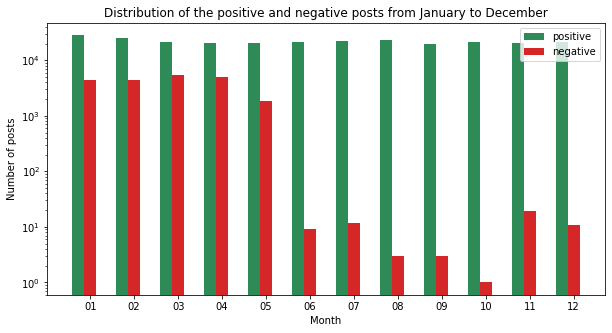

In [ ]:
# Grafical representation of the edges (+, -) distribution according to the month 
N = 12 # number of months in a year
ind = np.arange(N)  # the x locations for the groups
width = 0.27       # the width of the bars

fig = plt.figure(figsize = (10,5))
ax = fig.add_subplot(111)

 
month_pos = body_pos.groupby(data_body['TIMESTAMP'].dt.month).size()
rects1 = ax.bar(ind, month_pos, width, color='seagreen')
plt.yscale('log')
month_neg = body_neg.groupby(data_body['TIMESTAMP'].dt.month).size()
rects2 = ax.bar(ind+width, month_neg, width, color='tab:red')

ax.set_ylabel('Number of posts')
ax.set_xlabel('Month')
ax.set_title('Distribution of the positive and negative posts from January to December')
ax.set_xticks(ind+width)
ax.set_xticklabels( ('01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12'))
ax.legend( (rects1[0], rects2[0]), ('positive', 'negative') )

plt.show()

**Analysis :**
- All the month do have posts because we can see both red and green bars every where
- The difference between the number of positive and negative posts is huge, all along the year and depsite intern fluctation
- The number of negative posts is higher at the beginning of the year (01-05) than at the end of the year (06-12)
- So we can identify two main part on the graph : when we have both important green and red barplots (01-50) and when we have important red and small green. 

Let's compute the ratio to see if our trend identification is right. As before we begin by creation of the list containing the ratios for each month and then we plot it according to the associated month. Because ratio are also very different between each other we use log scale to plot all of them on a single graph.

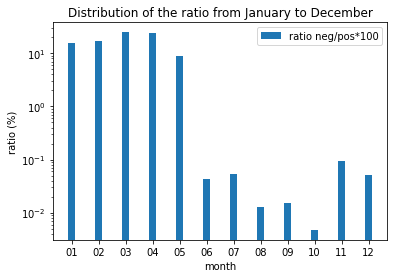

In [ ]:
# Grafical representation of the the ratio of edges (-/+*100) distribution according to the month 

ratio = [(int(b) / int(m))*100 for b,m in zip(month_neg, month_pos)]
N = 12
ind = np.arange(N)  # the x locations for the groups
width = 0.27       # the width of the bars

fig = plt.figure()
ax = fig.add_subplot(111)


rects1 = ax.bar(ind, ratio, width, color='tab:blue', label = 'ratio neg/pos*100')
plt.yscale('log')
ax.set_ylabel('ratio (%)')
ax.set_xlabel('month')
ax.set_title('Distribution of the ratio from January to December')
ax.set_xticks(ind)
ax.set_xticklabels( ('01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12'))
ax.legend()

plt.show()

**Analysis :**
- So we find the same two big parts : high ratio (month 01 to 05) and small ratio (06 to 12). However we can also notice differences in the high ratio part that were barely visible in the first graph : thus we can splitt this part into 2 : 01-02-05 with ratio between 10 and 15 and 03-04 with ratio around 25. 
- as we want to compare month network structure, we will pick one month representating of the of these 3 parts to draw sub-graphs. To do so we compute the mean of the amount of positive edges for the group and then we calculate the difference to this mean for each month part of the group. Then we will select the one closer to the mean.

In [ ]:
import statistics

In [ ]:
# 01 - 02 - 05 
mean_010205_pos = statistics.mean([month_pos.iloc[0], month_pos.iloc[1], month_pos.iloc[4]])
print('The mean count of posts from jan., feb and may is ', mean_010205_pos)
print('The difference between number of counts and mean for january, february and may is respectively: \n',[abs(x - mean_010205_pos) for x in [month_pos.iloc[0], month_pos.iloc[1], month_pos.iloc[4]]])

The mean count of posts from jan. to apr. is  24785
The difference between number of counts and mean for january, february and may is respectively: 
 [3358, 958, 4316]


So we see that the average value of positive post between january, february and may is 24785. We also see that the month with the number of counts the closer to this mean is **february** (it as the small difference, 958) and thus the more representative.

In [ ]:
# 03 - 04 
mean_0304_pos = statistics.mean([month_pos.iloc[2], month_pos.iloc[3]])
print('The mean count of posts from march to apr. is ', mean_0304_pos)
print('The difference between number of counts and mean for march and april is respectively: \n',[abs(x - mean_0304_pos) for x in [month_pos.iloc[2], month_pos.iloc[3]]])

The mean count of posts from jan. to apr. is  20917
The difference between number of counts and mean for march and april is respectively: 
 [574, 574]


So we see that the average number of positive counts between march and april is 20917. We also see that both are at equal distance to the mean. We will choose **march** because it has a high number of votes and thus might be more rich in the further analysis. 

In [ ]:
# 06 - 12 
mean_0612_pos = statistics.mean([month_pos.iloc[5], month_pos.iloc[6], month_pos.iloc[7], month_pos.iloc[8], month_pos.iloc[9], month_pos.iloc[10], month_pos.iloc[11]])
print('The mean count of posts from june. to dec. is ', mean_0612_pos)
print('The difference between number of counts and mean for march and april is respectively: \n',[abs(x - mean_0612_pos) for x in [month_pos.iloc[5], month_pos.iloc[6], month_pos.iloc[7], month_pos.iloc[8], month_pos.iloc[9], month_pos.iloc[10], month_pos.iloc[11]]])


The mean count of posts from jan. to apr. is  21328
The difference between number of counts and mean for march and april is respectively: 
 [144, 984, 1867, 1806, 261, 800, 166]


So we see that the average number of positive edges between june and december is 21328. We also see that the month closer to this average is **june** (difference smaller, 144) and thus it is the more representative.

**Ccl :** In order to assess the impact of the **MONTH** on the structure of the network, we can compare 3 subgraphs : 
> - from february (representative of the first group -middle ratio -)
> - from march (representative of the second group, -higher ratio)
> - from june (representative of the third group, -small ratio-)

### Step 3: Analysis of the day
Then we continue with the analysis of the day. We follow the same pipeline. So here are the number of edges associated to each day of the month.

In [ ]:
day_positive = body_pos.groupby(data_body['TIMESTAMP'].dt.day).size()
day_negative = body_neg.groupby(data_body['TIMESTAMP'].dt.day).size()
print('Month Positive', day_positive)
print('Month Negative', day_negative)

Month Positive TIMESTAMP
1     8535
2     9120
3     8966
4     8436
5     8690
6     8941
7     8561
8     8572
9     8645
10    8825
11    9029
12    8810
13    8715
14    8367
15    8887
16    9349
17    9153
18    8787
19    8666
20    9198
21    8516
22    8610
23    8393
24    8400
25    8424
26    8318
27    8778
28    8299
29    8217
30    8236
31    5048
dtype: int64
Month Negative TIMESTAMP
1     671
2     764
3     777
4     773
5     742
6     909
7     770
8     806
9     767
10    797
11    855
12    625
13    631
14    618
15    628
16    692
17    738
18    617
19    637
20    603
21    586
22    640
23    640
24    691
25    683
26    630
27    659
28    664
29    561
30    531
31    365
dtype: int64


So we see that all the 31 days of a month are represented in the dataset. 

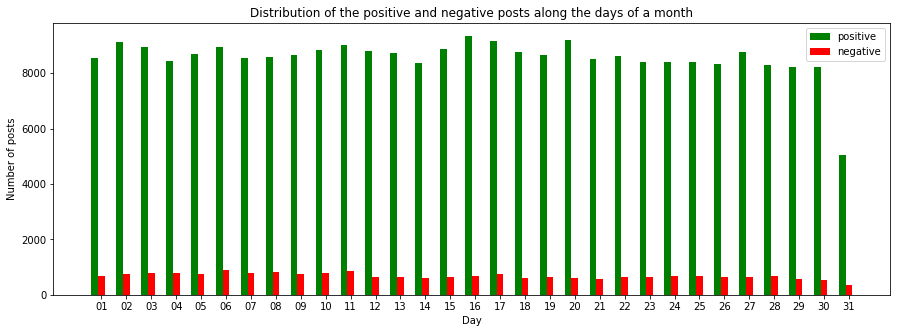

In [ ]:
# Grafical representation of the edges (+, -) distribution according to the day of the month 
N = 31 #number of day in a month
ind = np.arange(N)  # the x locations for the groups
width = 0.27       # the width of the bars

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)

 
day_pos = body_pos.groupby(data_body['TIMESTAMP'].dt.day).size()
rects1 = ax.bar(ind, day_pos, width, color='g')
day_neg = body_neg.groupby(data_body['TIMESTAMP'].dt.day).size()
rects2 = ax.bar(ind+width, day_neg, width, color='r')

ax.set_ylabel('Number of posts')
ax.set_xlabel('Day')
ax.set_title('Distribution of the positive and negative posts along the days of a month')
ax.set_xticks(ind+width)
ax.set_xticklabels( ('01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26' ,'27', '28', '29', '30', '31'))
ax.legend((rects1[0], rects2[0]), ('positive', 'negative'))

plt.show()

**Analysis :** 
- the abrupt decrease for day 31 is because only half of the month in a year have a 31th day, so obviously there are less posts (pos and neg) done that day
- the amount of negative edges is very small compared to amount of positif edges, for all the days 
- General manner : both positive and negative counts seams to be relatively constant along the days of a month, they are some fluctuations (more visible for positive posts) but it is hard to highlight clear trend. 

**Ccle :** We need to do further analysis on the days to be able to identify trends. So we are going to look at the number of posts according to the day of the week: monday, tuesday ... sunday. 

To be sure we don't miss any trend according to the day of the year, we compute the ratio. 

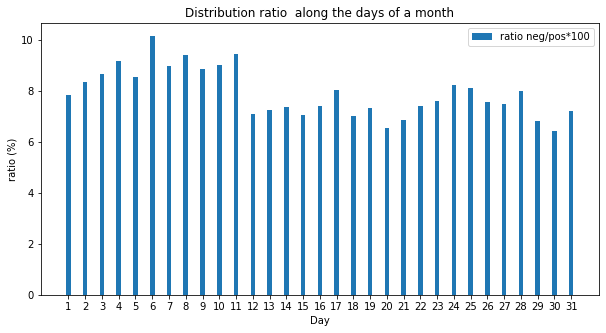

In [ ]:
# Grafical representation of the the ratio of edges (-/+*100) distribution according to the day of the month 

ratio = [(int(b) / int(m))*100 for b,m in zip(day_neg, day_pos)]
N = 31
ind = np.arange(N)  # the x locations for the groups
width = 0.27       # the width of the bars

fig = plt.figure(figsize = (10,5))
ax = fig.add_subplot(111)

rects1 = ax.bar(ind, ratio, width, color='tab:blue', label ='ratio neg/pos*100')

ax.set_ylabel('ratio (%)')
ax.set_xlabel('Day')
ax.set_title('Distribution ratio  along the days of a month')
ax.set_xticks(ind)
ax.set_xticklabels( ('1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26' ,'27', '28', '29', '30', '31'))
ax.legend()
plt.show()

**Analysis :**
- It is still hard to identify a trend
- we could split it according to different range of ratios, but values seams to be quite continuous so it would be very arbitrary to define ranges among them 

Have to look on the day og the week to try to identify pattern

#### Step 3 : cont. Analysis day of the week

So now we focus on the analysis of possible trend in the amount of edges according to the day of the week. As before we start by showing the amount of positive and negative edges according to the day. The week is numbered from 0 (corresponds to monday) to 6 (corresponds to sunday).

In [ ]:
day_positive = body_pos.groupby(data_body['TIMESTAMP'].dt.weekday).size()
day_negative = body_neg.groupby(data_body['TIMESTAMP'].dt.weekday).size()
print('Month Positive', day_positive)
print('Month Negative', day_negative)

Month Positive TIMESTAMP
0    40390
1    40945
2    40052
3    39617
4    37373
5    32527
6    34587
dtype: int64
Month Negative TIMESTAMP
0    3101
1    3458
2    3145
3    3123
4    2956
5    2542
6    2745
dtype: int64


So the days reprensented in the dataset are from 0 (monday) to 6 (sunday). 

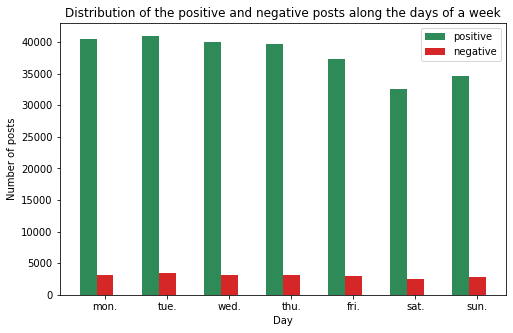

In [ ]:
# Grafical representation of the edges (+, -) distribution according to the day of the week 
N = 7 #number of day in a week
ind = np.arange(N)  # the x locations for the groups
width = 0.27       # the width of the bars

fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111)

 
dayw_pos = body_pos.groupby(data_body['TIMESTAMP'].dt.weekday).size()
rects1 = ax.bar(ind, dayw_pos, width, color='seagreen')
dayw_neg = body_neg.groupby(data_body['TIMESTAMP'].dt.weekday).size()
rects2 = ax.bar(ind+width, dayw_neg, width, color='tab:red')

ax.set_ylabel('Number of posts')
ax.set_xlabel('Day')
ax.set_title('Distribution of the positive and negative posts along the days of a week')
ax.set_xticks(ind+width)
ax.set_xticklabels( ('mon.', 'tue.', 'wed.', 'thu.', 'fri.', 'sat.', 'sun.'))
ax.legend((rects1[0], rects2[0]), ('positive', 'negative'))

plt.show()

**Analysis :**
- As for the other parameter (year, month, day of the month), the amount of positive posts is higher than the amount of negative posts
- The amount of negative posts is quite constant along the week 
- the amount of positive posts is globally smaller the week end, and could be seen as constant during the week. It might be explained by the routine of the week, so the habits of beeing on the website for coffe break for example, while the week end, the events are more random and technology connection can be smaller. Also we can see a subtil trend along the week we a sligth decrease in number of positive edges (so not constant anymore), this might be due to the tireing and fedding up of people along the week. But again, here we want to analyse the impact of the trend, not the reason of the trend. Here are just some hypothesis to help to understand the trends in our mind.

We have to compute the ratio to see if the subtil evolution of positive edges along the workweek is actually a trend or not.

[7.677642980935875, 8.445475638051043, 7.852292020373515, 7.882979528990081, 7.909453348674177, 7.815045961816337, 7.936507936507936]


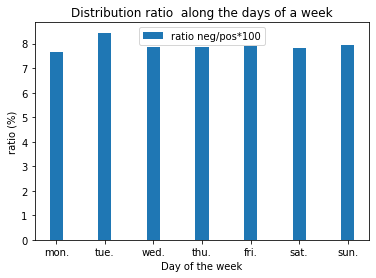

In [ ]:
# Grafical representation of the the ratio of edges (-/+*100) distribution according to the day of the week

ratio = [(int(b) / int(m))*100 for b,m in zip(dayw_neg, dayw_pos)]
print(ratio)
N = 7 # number of day of the week
ind = np.arange(N)  # the x locations for the groups
width = 0.27       # the width of the bars

fig = plt.figure()
ax = fig.add_subplot(111)

rects1 = ax.bar(ind, ratio, width, color='tab:blue', label = 'ratio neg/pos*100')

ax.set_ylabel('ratio (%)')
ax.set_xlabel('Day of the week')
ax.set_title('Distribution ratio  along the days of a week')
ax.set_xticks(ind)
ax.set_xticklabels( ('mon.', 'tue.', 'wed.', 'thu.', 'fri.', 'sat.', 'sun.'))
ax.legend()
plt.show()

**Analysis :**
- here we can see that in fact the ratio of positive and negative edge is quite the same all along the week (~ 7%)
- there is only in tuesday that the ratio is a bit bigger (>8%).
- these trends are definitively not obvious and we will have to keep it in mind when analysis the network structure parameters on the following steps

**Ccl :** We can do analysis on the subset from tuesday, and one from another day of the week (ratio is similar) but as the difference is not very big, not sure we ll see something on the structure of the network.So we choose : 
>- Tuesday : representative of the bigger ratio (>8%)
>- Saturday : reprensetative of the "constant" ratio (~7%)

One can see here that the subtil trend we have identified in the previous graph is not visible here. It means that the amount of both positive and negative edges have quite the same evolution along the week (despite tuesday). 

### Step 4: Analysis of the hour 

Now let's have a look on hour's trend. First we print the amount of edges associated to each hour of the day. We can see that they have quite the same magnitude order. Thus we will be able to plot them on the same graph without using log scale.

In [ ]:
hour_positive = body_pos.groupby(data_body['TIMESTAMP'].dt.hour).size()
hour_negative = body_neg.groupby(data_body['TIMESTAMP'].dt.hour).size()
print('Month Positive', hour_positive)
print('Month Negative', hour_negative)

Month Positive TIMESTAMP
0      7089
1      6045
2      5634
3      6100
4      6867
5      7819
6      9938
7     12069
8     13372
9     14426
10    14189
11    14887
12    14571
13    14617
14    14994
15    14149
16    13267
17    13167
18    12418
19    11889
20    10925
21     9900
22     8934
23     8225
dtype: int64
Month Negative TIMESTAMP
0      423
1      378
2      368
3      331
4      433
5      509
6      835
7      830
8      983
9     1335
10    1167
11    1347
12    1232
13    1208
14    1345
15    1185
16    1091
17    1059
18    1025
19     961
20     892
21     816
22     757
23     560
dtype: int64


So we see that all the 24h of the day are represented. The date use the convention 00 for mid night. Now let's grafically present the results. 

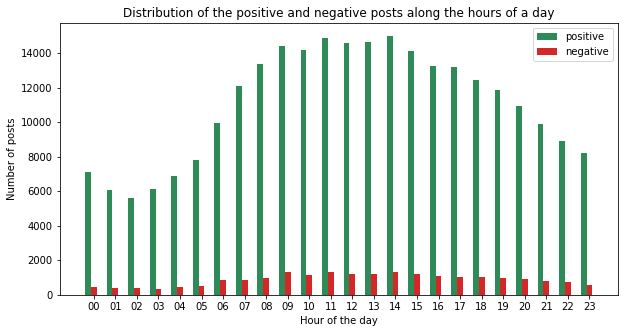

In [ ]:
# Grafical representation of the edges (+, -) distribution according to the hours of the day 
N = 24 #number of hours along a day
ind = np.arange(N)  # the x locations for the groups
width = 0.27       # the width of the bars

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)

hour_pos = body_pos.groupby(data_body['TIMESTAMP'].dt.hour).size()
rects1 = ax.bar(ind, hour_pos, width, color='seagreen')
hour_neg = body_neg.groupby(data_body['TIMESTAMP'].dt.hour).size()
rects2 = ax.bar(ind+width, hour_neg, width, color='tab:red')

ax.set_ylabel('Number of posts')
ax.set_xlabel('Hour of the day')
ax.set_title('Distribution of the positive and negative posts along the hours of a day')
ax.set_xticks(ind+width)
ax.set_xticklabels(('00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23'))
ax.legend((rects1[0], rects2[0]), ('positive', 'negative'))

plt.show()

**Analysis :**
- In a general manner : seams to have more edges (both positive and negative) during the day than during the night. As the two sign seams to have the same evolution we'll have to compute the ratio to see if it is effectively a trend 

The "wave" profile of the bar plot may be explained by the activity evolution of people along a day.

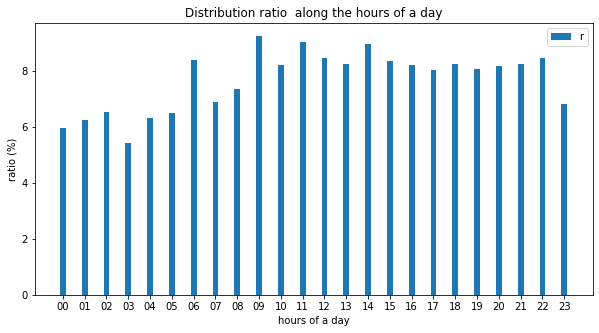

In [ ]:
# Grafical representation of the the ratio of edges (-/+*100) distribution according to the hour of the day 
ratio = [(int(b) / int(m))*100 for b,m in zip(hour_neg, hour_pos)]
N = 24 #number of hours in a day
ind = np.arange(N)  # the x locations for the groups
width = 0.27       # the width of the bars

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)

rects1 = ax.bar(ind, ratio, width, color='tab:blue', label = 'ratio neg/pos*100')

ax.set_ylabel('ratio (%)')
ax.set_xlabel('hours of a day')
ax.set_title('Distribution ratio  along the hours of a day')
ax.set_xticks(ind)
ax.set_xticklabels(('00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23'))
ax.legend('ratio')
plt.show()

**Analysis :**
- we can identify three part : low ration (5-7) for 0h, 1h, 2h, 3h, 4h, 5h, 7h and 23h ; middle ratio (8) for 6h, 10h, 12h, 13h, 15h, 16h, 17h, 18h, 19h, 20h, 21h and 22h ; high ratio (9) for 9h, 11h and 14h.
- As we want to draw sub-graphs according to the hour of the day relevant of this trend, we need to find a relevent hour for each of these parts. To do so, as previously done we compute the mean of the amount of positive edges of a group and then the difference to the mean of the amount of positive edges for each hour of the group. We finally selecte the one closest to the mean.

In [ ]:
# ratio 5-7 
mean_r57_pos = statistics.mean([hour_pos.iloc[0], hour_pos.iloc[1], hour_pos.iloc[2], hour_pos.iloc[3], hour_pos.iloc[4], hour_pos.iloc[5], hour_pos.iloc[7], hour_pos.iloc[23]])
print('The mean count of posts from jan. to apr. is ', mean_r57_pos)
print('The difference between number of counts and mean for march and april is respectively: \n',[abs(x - mean_r57_pos) for x in[hour_pos.iloc[0], hour_pos.iloc[1], hour_pos.iloc[2], hour_pos.iloc[3], hour_pos.iloc[4], hour_pos.iloc[5], hour_pos.iloc[7], hour_pos.iloc[23]]])


The mean count of posts from jan. to apr. is  7481
The difference between number of counts and mean for march and april is respectively: 
 [392, 1436, 1847, 1381, 614, 338, 4588, 744]


- the more representative for the ratio 5-7 is **7h**. 

In [ ]:
# ratio 8
mean_r8_pos = statistics.mean([hour_pos.iloc[6], hour_pos.iloc[10], hour_pos.iloc[12], hour_pos.iloc[13], hour_pos.iloc[15], hour_pos.iloc[16], hour_pos.iloc[17], hour_pos.iloc[18], hour_pos.iloc[19], hour_pos.iloc[20], hour_pos.iloc[21], hour_pos.iloc[22]])
print('The mean count of posts from jan. to apr. is ', mean_r8_pos)
print('The difference between number of counts and mean for march and april is respectively: \n',[abs(x - mean_r8_pos) for x in [hour_pos.iloc[6], hour_pos.iloc[10], hour_pos.iloc[12], hour_pos.iloc[13], hour_pos.iloc[15], hour_pos.iloc[16], hour_pos.iloc[17], hour_pos.iloc[18], hour_pos.iloc[19], hour_pos.iloc[20], hour_pos.iloc[21], hour_pos.iloc[22]]])

The mean count of posts from jan. to apr. is  12330
The difference between number of counts and mean for march and april is respectively: 
 [2392, 1859, 2241, 2287, 1819, 937, 837, 88, 441, 1405, 2430, 3396]


- the most representative is **18h**.

In [ ]:
# ratio 9
mean_r9_pos = statistics.mean([hour_pos.iloc[9], hour_pos.iloc[11], hour_pos.iloc[14]])
print('The mean count of posts from jan. to apr. is ', mean_r9_pos)
print('The difference between number of counts and mean for march and april is respectively: \n',[abs(x - mean_r9_pos) for x in [hour_pos.iloc[9], hour_pos.iloc[11], hour_pos.iloc[14]]])

The mean count of posts from jan. to apr. is  14769
The difference between number of counts and mean for march and april is respectively: 
 [343, 118, 225]


- the most representative is **12h**.

**Ccl :** In order to assess the impact of the **HOUR** on the structure of the network, we can compare  3 subgraphs : 
> - from 7h (representative of the first group - ratio 5-7 -)
> - from 18h (representative of the second group, -ratio 8-)
> - from 12h (representative of the third group, -ration 9-)

### 2.1.1.2] Do the structural analysis of these subgraphs 

First, let's define the parameters representative of structure network we will investigate here. The three three characteristics of network structrue we want to study here are the **centrality**, the **clustering** and the **behavior**. Do do se we will computer in total  parameters: 

<br></br>
- Centrality :
>* Degree  : it corresponds to the number of incoming edges onto the node and will give a sense of how connected the nodes are in the graphs
>* Clossness : this index quantifies the node’s relationship to all other nodes in the network by taking into account the indirect connections from that node. Thus, a high closeness index indicates a short average distance of a given node to all the other nodes; also a  node with high closeness will be affected quickly by changes in any part of the network (butterfly effect) and its own changes can have consequences on other parts of the network rapidly. In other word it tells how close the nodes are to each other.
>* Local clustering coefficient : it is the ratio of edges that exist between the neighbours of a particular node relative and the total number of all possible edges between these neighbours. It can give cues on the local redundancy of the given node: if we remove this node, may it have an impact on the capacity of its neighbor to communicate and influence each other? Big local clustering coefficient menas that the impact will be small because neighbor nodes will still be able to communicate while small coefficients reveal possible bad consequences for neighbor communication in case of removal. In other words it gives information on the degree of how nodes cluster together with the neighbor nodes.
>* Centrality :  It is  the number of edges attached to the node, incoming and outcoming combined
- Clustering : 
>* Global clustering coefficient : it is the ratio of  the number of closed triplets (or 3 x triangles) over the total number of triplets (both open and closed). It gives an idea of the clustering in the whole network.
- Behavior : 
>* Assortativity : it represents for a node the preference to attach other nodes that are similar in some way.Positive values of r indicate a correlation between nodes of similar degree, while negative values indicate relationships between nodes of different degree. In general, r lies between −1 and 1. When r = 1, the network is said to have perfect assortative mixing patterns, when r = 0 the network is non-assortative, while at r = −1 the network is completely disassortative.
<br></br>

For the properties Degree, Closeness, Local clustering coefficient and Centrality the max, min and average value for the subgraph is calculated. The average value will give a sense of parameter within the subgraph and the max, min value will give a rough indication of how big the spread is, in the form of outliers.
 
We begin with defining a function that gets all the properties, that are interesting to compare, for a subgraph. This is made by mostly using build-in functions from the library networkx to get the properties in an efficient way.

In [7]:
def graph_properties(G,weights="None"):
    """
    Calculate parameters for a subgraph. If weights is given for the network then this is taken into account 
    during the calculation of the degree. 

    Return a dataframe with all the parameters for the network, with rounded number to one decimal. 

    Input:
    G - Graph
    W(Optinal) - Weights inside the graph 

    Output:
    df - Dataframe containing average,min and max for degree, clustering and closeness
    """

# Degree 
    degree_sequence = sorted([d for n, d in G.degree()], reverse=True)
    min_degree = min(degree_sequence)
    max_degree = max(degree_sequence)
    average_degree = np.mean(degree_sequence)

# Centrality
    centrality = [node_cent for node,node_cent in (nx.degree_centrality(G)).items()]
    min_centrality = min(centrality)
    max_centrality = max(centrality)
    average_centrality = np.mean(centrality)
    
    
# Assortativity
    assortativity_degree = nx.degree_assortativity_coefficient(G)

#Closeness
    closeness = [node_c for node,node_c in (nx.closeness_centrality(G)).items()]
    min_closeness = min(closeness)
    max_closeness = max(closeness)
    average_closeness = np.mean(closeness)

#Clustering
    clustering = [clusters for node,clusters in (nx.clustering(G)).items()]
    min_cluster = min(clustering)
    max_cluster = max(clustering)
    average_cluster = np.mean(clustering)

    global_cluster = nx.transitivity(G)

  

    data = {'Average': [average_degree,average_closeness,average_cluster,average_centrality],
       'Max': [max_degree,max_closeness,max_cluster,max_centrality],
       'Min': [min_degree,min_closeness,min_cluster,min_centrality]}
    properties_graph = pd.DataFrame(data)
    properties_graph.index=['Degree','Closeness','Local clustering coefficient','Centrality']
    properties_graph.round(1)

    
    
    
    data = {'': [global_cluster,assortativity_degree]}
    properties2_graph = pd.DataFrame(data)
    properties2_graph.index=['Global clustering coefficient','Assortativity degree']
    properties2_graph.round(1)

    

    
    

    return properties_graph,properties2_graph

### Computation of the parameters for the Reddits subgraphs 

To compare the differente subgraph according to these properites the function is called on every subgraph. After that an analyze is made of the result. 

#### Reddit - Year 

We begin by taking out the year we want to investigate. As previous written this is the year 2014 and 2016 for the reddit dataset. 
Reminder : 
- 2014 : high ratio
- 2016 : low ratio

In [ ]:
mask_2014 = (data_body['TIMESTAMP'] > '2014-1-1') & (data_body['TIMESTAMP'] <= '2014-12-31')
mask_2016 = (data_body['TIMESTAMP'] > '2016-1-1') & (data_body['TIMESTAMP'] <= '2016-12-31')

reddit_2014 = data_body.loc[mask_2014]
reddit_2016 = data_body.loc[mask_2016]


Printing the data frame to see that everthing looks fine 

In [ ]:
reddit_2016.head()

In [ ]:
reddit_2014.head()

The two subgraphs are created using networkx. 

In [ ]:
import networkx as nx 
reddit_2014_graph = nx.from_pandas_edgelist(reddit_2014,"SOURCE_SUBREDDIT","TARGET_SUBREDDIT",edge_attr="Sign",create_using=nx.DiGraph)
reddit_2016_graph = nx.from_pandas_edgelist(reddit_2016,"SOURCE_SUBREDDIT","TARGET_SUBREDDIT",edge_attr="Sign",create_using=nx.DiGraph)

To get the properties of the subgrahp the function graph properties is called.

In [ ]:
reddit_2014_table1,reddit_2014_table2= graph_properties(reddit_2014_graph)
reddit_2016_table1,reddit_2016_table2 = graph_properties(reddit_2016_graph)

Printing out the result for the first table containing degree, clossness, local cluster coefficient and centrality.  

In [ ]:
reddit_2014_table1.head()

,Average,Max,Min
Degree,5.768021,1144.000000,1.00000
Closeness,0.077004,0.283545,0.00000
Local clustering coefficient,0.104383,1.000000,0.00000
Centrality,0.000460,0.091330,0.00008


In [ ]:
reddit_2016_table1.head()

,Average,Max,Min
Degree,5.856623,947.000000,1.000000
Closeness,0.067397,0.252930,0.000000
Local clustering coefficient,0.105627,1.000000,0.000000
Centrality,0.000300,0.048564,0.000051


**Centrality Analysis :**
- The table 2016, which is the subgraph with a higher amount of positive votes, shows a higher average degree per nodes. However, at the same trend is not have a significant difference, the closeness and centrality are at the same time higher in the nodes in the 2014 subgraph. This is somewhat contradictory as centrality is highly linked to the degree of the nodes. 

One can conclude that it did not show any big difference between the two subgraphs. To further investigate the analyses will be made by creating graphs on the other parameters, that were given under the previous chapter. 

-------

In [ ]:
reddit_2014_table2.head()

,
Global clustering coefficient,0.052295
Assortativity degree,-0.073850


In [ ]:
reddit_2016_table2.head()

,
Global clustering coefficient,0.051884
Assortativity degree,-0.068114


**Clustering and Behavior analysis :**
- Regardring the information above the difference is very small between the two subgraphs. Thus one could say that sub-graphs seem to be quite similar even if they are built from two year with a big difference in the ratio of negative/positive edges (2014, high ratio versus 2016, low one).

-------


#### Reddit - Month

After the year the analyse is continued comapring the months. 
Reminder : 
- february : middle ratio
- march : high ratio 
- june : low ratio

We follow the same steps as before. For clarity purpose we won't repeat the comments each time. If precision needed refer to the year analysis computation above.

In [ ]:
mask_feb = (data_body['TIMESTAMP'].dt.month == 2)
mask_march = (data_body['TIMESTAMP'].dt.month == 3)
mask_june = (data_body['TIMESTAMP'].dt.month == 6)

reddit_feb = data_body.loc[mask_feb]
reddit_march = data_body.loc[mask_march]
reddit_june = data_body.loc[mask_june]

In [ ]:
reddit_feb_graph = nx.from_pandas_edgelist(reddit_feb,"SOURCE_SUBREDDIT","TARGET_SUBREDDIT",edge_attr="Sign",create_using=nx.DiGraph)
reddit_march_graph = nx.from_pandas_edgelist(reddit_march,"SOURCE_SUBREDDIT","TARGET_SUBREDDIT",edge_attr="Sign",create_using=nx.DiGraph)
reddit_june_graph = nx.from_pandas_edgelist(reddit_june,"SOURCE_SUBREDDIT","TARGET_SUBREDDIT",edge_attr="Sign",create_using=nx.DiGraph)

In [ ]:
reddit_feb_table1,reddit_feb_table2 = graph_properties(reddit_feb_graph)
reddit_march_table1,reddit_march_table2 = graph_properties(reddit_march_graph)
reddit_june_table1,reddit_june_table2 = graph_properties(reddit_june_graph)

In [ ]:
reddit_feb_table1.head()

,Average,Max,Min
Degree,4.060255,456.000000,1.0000
Closeness,0.041900,0.191927,0.0000
Local clustering coefficient,0.071444,1.000000,0.0000
Centrality,0.000405,0.045495,0.0001


In [ ]:
reddit_june_table1.head()

,Average,Max,Min
Degree,3.915435,437.000000,1.00000
Closeness,0.041402,0.193965,0.00000
Local clustering coefficient,0.055777,1.000000,0.00000
Centrality,0.000470,0.052499,0.00012


In [ ]:
reddit_march_table1.head()

,Average,Max,Min
Degree,4.211471,534.000000,1.000000
Closeness,0.044221,0.199613,0.000000
Local clustering coefficient,0.066476,1.000000,0.000000
Centrality,0.000398,0.050463,0.000095


**Centrality analysis :**

- one can see that march nodes have a higher degree and closeness.
- February has a higher degree, closeness, and local clustering coefficient than June.
- One thing to notice is that the higher degree the subgraph has a higher max number of the highest node it has. This might seem logical, but it can be depending on it is one node that makes the higher average or that the degrees of the nodes are higher on average.

To get a better understanding this needs to be investigating more. 

-----

In [ ]:
reddit_feb_table2.head()

,
Global clustering coefficient,0.111181
Assortativity degree,-0.043712


In [ ]:
reddit_june_table2.head()

,
Global clustering coefficient,0.038852
Assortativity degree,-0.036498


In [ ]:
reddit_march_table2.head()

,
Global clustering coefficient,0.073097
Assortativity degree,-0.040618


**Clustering and Behavior analysis :**
- Here one can see that the global clustering coefficient is higher in februrary (middle ratio) than in march (high) and june (low)
- the Assortativity seems quite constant among the months studies


Together with centrality analysis, we may conclude that there does not seem to be much of a trend between the number of positive edges and the investigated properties, because the difference don't appear to be statistically significant.


-----

#### Reddit - Day

Regarding the days of the week, two different days will be chosen to compare. Tuesday had a bigger ratio between positive and negative posts, therefore this will be a subgraph. Because the rest of the weekdays were pretty similar it does not matter which to are compared. To get contrast Saturday was chosen, to see if the weekend possibly will give different properties graph. This could in that case be because the user mode is affected by the day of the week.  

In [ ]:
data_body.head()

,SOURCE_SUBREDDIT,TARGET_SUBREDDIT,POST_ID,TIMESTAMP,LINK_SENTIMENT,PROPERTIES,Sentiment
0,leagueoflegends,teamredditteams,1u4nrps,2013-12-31 16:39:58,1,"345.0,298.0,0.75652173913,0.0173913043478,0.08...",0.1748
1,theredlion,soccer,1u4qkd,2013-12-31 18:18:37,-1,"101.0,98.0,0.742574257426,0.019801980198,0.049...",0.5538
2,inlandempire,bikela,1u4qlzs,2014-01-01 14:54:35,1,"85.0,85.0,0.752941176471,0.0235294117647,0.082...",0.0000
3,nfl,cfb,1u4sjvs,2013-12-31 17:37:55,1,"1124.0,949.0,0.772241992883,0.0017793594306,0....",0.9672
4,playmygame,gamedev,1u4w5ss,2014-01-01 02:51:13,1,"715.0,622.0,0.777622377622,0.00699300699301,0....",0.8906


In [ ]:

mask_tuesday = (data_body['TIMESTAMP'].dt.weekday == 1)
reddit_tuesday = data_body.loc[mask_tuesday]

mask_saturday = (data_body['TIMESTAMP'].dt.weekday == 5)
reddit_saturday = data_body.loc[mask_saturday]


In [ ]:
reddit_tuesday_graph = nx.from_pandas_edgelist(reddit_tuesday,"SOURCE_SUBREDDIT","TARGET_SUBREDDIT",edge_attr="Sign",create_using=nx.DiGraph)
reddit_saturday_graph = nx.from_pandas_edgelist(reddit_saturday,"SOURCE_SUBREDDIT","TARGET_SUBREDDIT",edge_attr="Sign",create_using=nx.DiGraph)

In [ ]:
reddit_tuseday_table1,reddit_tuesday_table2 = graph_properties(reddit_tuesday_graph)
reddit_saturday_table1,reddit_saturday_table2 = graph_properties(reddit_saturday_graph)

In [ ]:
reddit_tuseday_table1

,Average,Max,Min
Degree,4.443965,737.000000,1.000000
Closeness,0.050463,0.222599,0.000000
Local clustering coefficient,0.070541,1.000000,0.000000
Centrality,0.000320,0.053052,0.000072


In [ ]:
reddit_saturday_table1

,Average,Max,Min
Degree,4.123237,571.000000,1.000000
Closeness,0.043716,0.198134,0.000000
Local clustering coefficient,0.063207,1.000000,0.000000
Centrality,0.000336,0.046544,0.000082


**Centrality analysis :**
- Tuesday has a higher average degree, closeness, local clustering coefficient. It has a lower average centrality value but as it is already very very small this difference may be negligeable.
- Node degree is more speard out for tuesday than saturday, so as the closeness

This may be relation to that Tuesday has a higher amount of negative edges per amount of positive edges compared to Saturday. 

-------

In [ ]:
reddit_tuesday_table2

,
Global clustering coefficient,0.049076
Assortativity degree,-0.045391


In [ ]:
reddit_saturday_table2

,
Global clustering coefficient,0.049217
Assortativity degree,-0.035436


**Clusetering and Behavior analysis :**
- Almost the same global clustering coefficient for both days
- Assortativity less smaller for tuesday : nodes tend to do edges with less similar ones

So here we may say that the tuesday sub-graph has a higher centrality than the one from saturday, however because the global clustering coefficient is equal for both days we cannot say precisly how it affects the connectivity. We may also say that the nodes tend to bind more different ones in tuesday, thus groups formed are more heterogeneous than in saturday and thus by extend, other days of the week.

--------

-----

#### Reddit - hour 

Let's have a look on hour's sub-graphs. 
Reminder : 
- 7h : low ratio
- 18h : middle ratio
- 12h : high ration

In [ ]:
mask_7h = (data_body['TIMESTAMP'].dt.hour == 7)
mask_18h = (data_body['TIMESTAMP'].dt.hour == 18)
mask_12h = (data_body['TIMESTAMP'].dt.hour == 12)

reddit_7h = data_body.loc[mask_7h]
reddit_18h = data_body.loc[mask_18h]
reddit_12h = data_body.loc[mask_12h]

In [ ]:
reddit_7h.head()

,SOURCE_SUBREDDIT,TARGET_SUBREDDIT,POST_ID,TIMESTAMP,Sign,PROPERTIES,Sentiment
16,kpop,dota2,1u5qg2s,2014-01-01 07:05:10,1,"1050.0,938.0,0.705714285714,0.0419047619048,0....",0.9136
17,airsoft,airsoftmarket,1u5r7js,2014-01-01 07:09:16,1,"3788.0,3206.0,0.737856388596,0.0145195353749,0...",0.9891
21,fl_vapers,vaperequests,1u5uchs,2014-01-03 07:21:14,1,"218.0,197.0,0.756880733945,0.0137614678899,0.0...",0.0000
30,metafitnesscirclejerk,fitnesscirclejerk,1u6b38s,2014-01-03 07:20:26,1,"162.0,149.0,0.777777777778,0.0123456790123,0.0...",0.4927
46,bluebirds,soccer,1u6y0qs,2014-01-01 07:52:46,1,"223.0,215.0,0.704035874439,0.0582959641256,0.0...",0.4404


In [ ]:
reddit_18h.head()

,SOURCE_SUBREDDIT,TARGET_SUBREDDIT,POST_ID,TIMESTAMP,Sign,PROPERTIES,Sentiment
1,theredlion,soccer,1u4qkd,2013-12-31 18:18:37,-1,"101.0,98.0,0.742574257426,0.019801980198,0.049...",0.5538
5,dogemarket,dogecoin,1u4w7bs,2013-12-31 18:35:44,1,"1328.0,1110.0,0.768825301205,0.0143072289157,0...",0.9323
49,badhistory,worldpolitics,1u6zefs,2014-01-01 18:22:33,1,"2796.0,2433.0,0.775751072961,0.0125178826896,0...",-0.9950
56,minnesotavikings,nfl,1u73nms,2014-01-01 18:13:47,1,"423.0,359.0,0.77304964539,0.00709219858156,0.0...",0.7539
58,booksuggestions,books,1u75lns,2014-01-01 18:06:46,1,"1080.0,918.0,0.781481481481,0.00925925925926,0...",0.9766


In [ ]:
reddit_12h.head()

,SOURCE_SUBREDDIT,TARGET_SUBREDDIT,POST_ID,TIMESTAMP,Sign,PROPERTIES,Sentiment
27,politicaldiscussion,todayilearned,1u64d9s,2014-01-01 12:50:53,1,"232.0,213.0,0.771551724138,0.0172413793103,0.0...",0.4939
34,karmaconspiracy,funny,1u6fz3,2014-01-01 12:44:19,-1,"186.0,182.0,0.741935483871,0.0376344086022,0.0...",0.3182
41,highqualitygifs,bestof2013,1u6pq6s,2014-01-01 12:43:00,1,"1403.0,1331.0,0.700641482537,0.0306486101212,0...",0.9794
48,hailcorporate,firstworldanarchists,1u6zays,2014-01-01 12:19:58,1,"241.0,212.0,0.775933609959,0.0124481327801,0.0...",0.4215
67,hailcorporate,cfb,1u7gtms,2014-01-01 12:19:58,1,"966.0,818.0,0.760869565217,0.00931677018634,0....",0.3612


In [ ]:
reddit_7h_graph = nx.from_pandas_edgelist(reddit_7h,"SOURCE_SUBREDDIT","TARGET_SUBREDDIT",edge_attr="Sign",create_using=nx.DiGraph)
reddit_18h_graph = nx.from_pandas_edgelist(reddit_18h,"SOURCE_SUBREDDIT","TARGET_SUBREDDIT",edge_attr="Sign",create_using=nx.DiGraph)
reddit_12h_graph = nx.from_pandas_edgelist(reddit_12h,"SOURCE_SUBREDDIT","TARGET_SUBREDDIT",edge_attr="Sign",create_using=nx.DiGraph)


In [ ]:
reddit_7h_table1,reddit_7h_table2 = graph_properties(reddit_7h_graph)
reddit_18h_table1,reddit_18h_table2 = graph_properties(reddit_18h_graph)
reddit_12h_table1,reddit_12h_table2 = graph_properties(reddit_12h_graph)

In [ ]:
reddit_7h_table1.head()

,Average,Max,Min
Degree,3.213051,290.000000,1.00000
Closeness,0.024986,0.145379,0.00000
Local clustering coefficient,0.036419,1.000000,0.00000
Centrality,0.000483,0.043609,0.00015


In [ ]:
reddit_18h_table1.head()

,Average,Max,Min
Degree,3.081127,285.000000,1.000000
Closeness,0.023130,0.142895,0.000000
Local clustering coefficient,0.036773,1.000000,0.000000
Centrality,0.000439,0.040569,0.000142


In [ ]:
reddit_12h_table1.head()

,Average,Max,Min
Degree,3.260215,316.000000,1.000000
Closeness,0.028511,0.158988,0.000000
Local clustering coefficient,0.041013,1.000000,0.000000
Centrality,0.000416,0.040352,0.000128


**Centrality analysis :** 
- degree, clossness, local clustering coefficient and centrality is the higgest in the subgraph with higest ratio (12h). 
- The 6 pm subgraph, which has a medium level of positivie edges, has lower degree, clossness and centrality than the subgraph that represent the lowest level of postive edges (7 a.m)

What can be seen is that in every case where the degree and closeness is higher in average, the subgraphs node with max value in the two propeties is also higher. 

----

In [ ]:
reddit_7h_table2.head()

,
Global clustering coefficient,0.064473
Assortativity degree,-0.015193


In [ ]:
reddit_18h_table2.head()

,
Global clustering coefficient,0.028567
Assortativity degree,-0.008251


In [ ]:
reddit_12h_table2.head()

,
Global clustering coefficient,0.036184
Assortativity degree,-0.024376


**Clustering and Behavior analysis :**
- Global clustering coefficient higher for 7 a.m. than for 6 p.m and 12 a.m. (factor 2 and 3 respectively).
- The sub-graph 12 a.m. has the smaller assortativity degree 

As a recap the centrality is higher and the assortatitivity is smaller for sub-graph 12 a.m. (so its node tend to bind more dissimilar one and thus groups are more heterogeneous). On the other hand sub-graph 7 a.m has the higher global clusering coefficient, and thus is very connected even if not the more central.

-----

 ## 2.1.1.2] First conclusion

Here we aimed to analysis the impact of time variable on network structure. Let's do first a quick summary about the main results we got :
-  Year : as the differences between degree, closeness, local clustering coefficient and centrality are not big enough, they may not be statistically significant. Also the difference for global clustering and behavior are also very small. Thus it is hard to draw a conclusion about the impact of the year on Reddit subgraphs structure. *Here we may conclude that the year doesn't impact the structure, but we need further analysis with other structural parameter to ensure that*.
- Month : It is the same idea, the differences in parameters values are very small so we were really able to draw strong conclusion despite our analysis. As for year, *we may conclude that here the month doesn't have an impact on the Reddit network structure be we have to be careful in not taking this for strong thruth but more as an first assumption, because we need deeper analysis to really exclude this parameter*.

- Day : it appears that Tuesday, which has the high ratio, also has the higher average degree, closeness and local clustering coefficient. It also has the smaller assortativity. So we may say that tuesday appears to be more central and with groups more heterogeneous than saturday, and thus all the other day of the week which have the same ratio. *We can say that the day of the week may have an impact on the centrality and the behavior of the node and thus affect the global structure of the network*.

- Hour : it appears that all centrality parameters are higher in the subgraph with the highest ratio (12h). This sub-graph also has a low assortativity degree. However, it is the 7h sub-graph that has the higher global clustering coefficient. From these observation we could say that the network from 12h tends to be more heterogenous and central than the other, while the one from the morning 7h is more connected. Thus *we could say that the hour of the day tend to affect the centrality and connectivity of the network structure*.


So here we can see that the year and the month don't appear to impact a lot the structure while the day of the week and the hour seem to affect the structural parameter computed.

Let's draw a small sketch to have an idea on how these trend may influence edge analysis compared to status and balance analysis. As in the paper, we considere 3 nodes A, B and C. A is positively linked to B which is positively linked to C. We are studying the edge between A and C. According to the balance theory, it is likely to be positive as the triad type +++ is more plausible than ++-. On the other hand, the edge from C to A is more likely to be negative according to status theory. Let's consider the time now. Imagine that we are a Tuesday, thus the ratio of negative edge versus positive ones is higher. Thus the edge AC would be more likely to have negative sign than another day of the week, with a smaller ratio. Also on Tuesday, nodes tend to link to less similar nodes, thus we may consider so characteristics of A and C to evaluate the possibility of their connection. If they are similar, in tuesday they will be less likely to have a connection, if they are not similar it is the reverse. Now let's imagine that it is 12h (of whatever day of the week), then it is the similar observation, it is more likely that C binds A if they are not similar compared to another hour of the day. Thus we can see that these variables can have an impact on the edge / analysis prediction and so might be useful to take them into account during network structure analysis.

## 2.1.2] Work on the wikipedia and slashdot dataset

Then we apply the same pipeline of analysis to the wikipedia dataset, which is the only we have original associated datetime data. 
 
 ### 2.1.2.1] Identification of the global trend

### **Step 0**  : Work with TIMESTAMP  data

Load the wikipedia dataset. To do so we basically re-used the function constructed from previous replication work.

In [4]:

wikidata = [] #Declaring that wikidata is a list 
with open(wikipedia_file, "r",encoding='latin-1') as a_file: #Opening and reading data from Wikipedia. Use encoding so the format match.
    for line in a_file: #Iterating over every lines in the file 
        if "U	" in line: #When U   exist in a line, change the user id of the person being nominated
            candidate = [line for line in line.split()] #Splits up the line/string, where each word is a list item, to get the user id of the user to consider for a promotion
        if "V	" in line: #When V	 exists in a line we know that is a new voted 
            voter = [line for line in line.split()] #Splits up the line/string, where each word is a list item, to get the user id of the voter and the type of vote 
            if int(voter[1]) == 0: #If the user has voted 0, which is neutral, there is no link between the user that voted and the nominated user
                continue #We, therefore, want to continue to the next line
            else: #This means that the vote is 1 or -1
                wikidata.append(int(voter[2])) #Store the 3 element of the voter string, which is user id of voter 
                wikidata.append(int(candidate[1])) #Store the 2 element of the candidate string, which is user id of the nominated user
                wikidata.append(int(voter[1])) #Store the 2 element of the voter string, which is type of vote, 1 or -1
                wikidata.append(voter[3]+voter[4])
wikidata = np.reshape(wikidata, (int(len(wikidata)/4),4)) #Shapes the list to an array that has three columns and 1/3 of rows from the length of the list, because we now have split it up in three columns 

In [5]:
Wiki_votes = pd.DataFrame(data=wikidata,columns = ["FromNodeId", "ToNodeId","Sign","Date"])

So we need to convert, as for Reddit dataset.

In [6]:
Wiki_votes['Date'] = pd.to_datetime(Wiki_votes['Date'], format='%Y-%m-%d%H:%M:%S', errors='coerce')
Wiki_votes.head()


,FromNodeId,ToNodeId,Sign,Date
0,3,30,1,2004-09-14 16:26:00
1,25,30,-1,2004-09-14 16:53:00
2,4,30,1,2004-09-14 17:08:00
3,5,30,1,2004-09-14 17:37:00
4,6,30,1,2004-09-14 19:28:00


Then we check the type of the data.

In [ ]:
print('Exemple : the date of the first post of the dataset is : {}'.format(Wiki_votes['Date'][3]))
print(' Its type is ',type(Wiki_votes['Date'][3]))

Exemple : the date of the first post of the dataset is : 2004-09-14 17:37:00
 Its type is  <class 'pandas._libs.tslibs.timestamps.Timestamp'>


As we can see it is *timestamp*, thus we will be able to used specialized time functions (i.e. year, month, day and hour extracting). 

**split into positive and negative dataset**

*Positive*

In [ ]:
wiki_pos = Wiki_votes.copy()
wiki_pos = wiki_pos.drop(wiki_pos[wiki_pos.Sign == '-1'].index).reset_index(drop=True)
wiki_pos = wiki_pos.drop(wiki_pos[wiki_pos.Sign == '0'].index).reset_index(drop=True)
print('data body original .{}'.format(Wiki_votes.shape))
print('body POS {}'.format(wiki_pos.shape))

data body original .(107080, 4)
body POS (83962, 4)


In [ ]:
wiki_pos.head()

,FromNodeId,ToNodeId,Sign,Date
0,3,30,1,2004-09-14 16:26:00
1,4,30,1,2004-09-14 17:08:00
2,5,30,1,2004-09-14 17:37:00
3,6,30,1,2004-09-14 19:28:00
4,7,30,1,2004-09-14 19:37:00


In [ ]:
# check 
print('In data wiki votes : sign of post 1 = ', Wiki_votes['Sign'][1])
print('In wiki pos : sign of post 4 = ', wiki_pos['Sign'][1])

In data wiki votes : sign of post 1 =  -1
In wiki pos : sign of post 4 =  1


Here we can see that the line 4, originally containing a negative edges, has been replaced by a positvie one. Thus the transformation worked. We can check it over the all dataframe using the `unique()` function, as done for Reddit.

In [ ]:
print('Unique values in wiki_pos : {} '.format(wiki_pos['Sign'].unique()))

*Negative*

In [ ]:
wiki_neg = Wiki_votes.copy()
wiki_neg = wiki_neg.drop(wiki_neg[wiki_neg.Sign == '1'].index).reset_index(drop=True)
wiki_neg = wiki_neg.drop(wiki_neg[wiki_neg.Sign == '0'].index).reset_index(drop=True)
print('data body original .{}'.format(Wiki_votes.shape))
print('body POS {}'.format(wiki_neg.shape))


data body original .(107080, 4)
body POS (23118, 4)


In [ ]:
wiki_neg.head()

,FromNodeId,ToNodeId,Sign,Date
0,25,30,-1,2004-09-14 16:53:00
1,25,6,-1,2004-09-12 03:46:00
2,4,8,-1,2004-09-14 22:25:00
3,12,8,-1,2004-09-15 06:38:00
4,78,8,-1,2004-09-15 19:25:00


In [ ]:
# check 
print('In data wiki votes : sign of post 1 = ', Wiki_votes['Sign'][0])
print('In wiki pos : sign of post 1 = ', wiki_neg['Sign'][0])

We also test the efficiency of the filtering, but on the line 1 this time, because it contains a positive edge. We see it is well removed after filtering.We can check it over the all dataframe using the `unique()` function, as done for Reddit.

In [ ]:
print('Unique values in wiki_neg : {} '.format(wiki_neg['Sign'].unique()))

### Step 1 : Analysis of the year 

We follow exactly the same pipeline, so we won't detail the processes as much as we did for reddit because they are the same. What it intersting here is the analysis.

In [ ]:
# Just to have an idea of what it'll look like. 
year_positive_wiki = wiki_pos.groupby(wiki_pos['Date'].dt.year).size()
year_negative_wiki = wiki_neg.groupby(wiki_neg['Date'].dt.year).size()

print('Year Positive', year_positive_wiki)
print('Year Negative', year_negative_wiki)

Year Positive Date
2004     2569
2005    17057
2006    31915
2007    31903
2008      509
2063        1
2064        1
2065        1
2067        1
2070        1
2074        1
2086        1
2096        1
2105        1
dtype: int64
Year Negative Date
2004     748
2005    3161
2006    9806
2007    9294
2008     109
dtype: int64


In [ ]:
print(wiki_pos[wiki_pos['Date'].dt.year == 2063])

      FromNodeId ToNodeId Sign                Date
49060       4963     5092    1 2063-01-22 01:04:00


So here we have printed the years and the associated number of edges. As one can see, some of the year are not understandable as 2063. Thus we will filter the dataset to remove all the impossible years. We keep only the "plausible" one, with the condition that they are not in the future (<2020).

In [ ]:
wiki_neg = wiki_neg.drop(wiki_neg[wiki_neg['Date'].dt.year > 2020].index).reset_index(drop=True)
wiki_pos = wiki_pos.drop(wiki_pos[wiki_pos['Date'].dt.year > 2020].index).reset_index(drop=True)

In [ ]:
print(wiki_pos[wiki_pos['Date'].dt.year == 2063])

Empty DataFrame
Columns: [FromNodeId, ToNodeId, Sign, Date]
Index: []


Here we see the year 2063 was effectively removed. Now we re-print the years with the associated amounf of positive and negative edges.

In [ ]:
# Check again the year distribution 
year_positive_wiki = wiki_pos.groupby(wiki_pos['Date'].dt.year).size()
year_negative_wiki = wiki_neg.groupby(wiki_neg['Date'].dt.year).size()

print('Year Positive', year_positive_wiki)
print('Year Negative', year_negative_wiki)

Year Positive Date
2004     2569
2005    17057
2006    31915
2007    31903
2008      509
dtype: int64
Year Negative Date
2004     748
2005    3161
2006    9806
2007    9294
2008     109
dtype: int64


So years represented are from 2004 to 2008. 

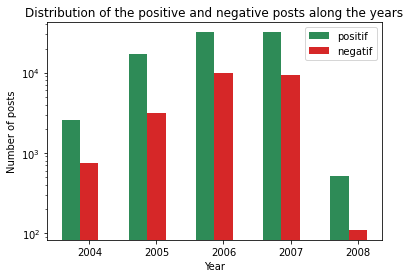

In [ ]:
# Grafical representation of the edges (+, -) distribution according to the year 
N = 5 # number of years presented : 2004 --> 2008
ind = np.arange(N)  # the x locations for the groups
width = 0.27       # the width of the bars

fig = plt.figure()
ax = fig.add_subplot(111)

 
year_pos_wiki = wiki_pos.groupby(wiki_pos['Date'].dt.year).size()
rects1 = ax.bar(ind, year_pos_wiki, width, color='seagreen')
plt.yscale('log')
year_neg_wiki = wiki_neg.groupby(wiki_neg['Date'].dt.year).size()
rects2 = ax.bar(ind+width, year_neg_wiki, width, color='tab:red')

ax.set_ylabel('Number of posts')
ax.set_xlabel('Year')
ax.set_title('Distribution of the positive and negative posts along the years')
ax.set_xticks(ind+width)
ax.set_xticklabels( ('2004', '2005', '2006', '2007', '2008'))
ax.legend((rects1[0], rects2[0]), ('positif', 'negatif'))

plt.show()

**Analysis :**
- So here both the amount of positive votes is higher than the negative ones, but both seams to have the same evolution along the year. We have to compute the ratio to make sure. 

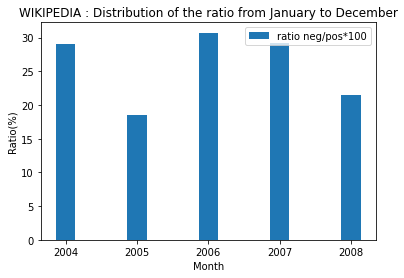

In [ ]:
# Grafical representation of of the edges ratio (+/-*100) according to the year 
ratio_wiki = [(int(b) / int(m))*100 for b,m in zip(year_neg_wiki, year_pos_wiki)]
N = 5
ind = np.arange(N)  # the x locations for the groups
width = 0.27       # the width of the bars

fig = plt.figure()
ax = fig.add_subplot(111)


rects1 = ax.bar(ind, ratio_wiki, width, color='tab:blue', label = 'ratio neg/pos*100')
ax.set_ylabel('Ratio(%)')
ax.set_xlabel('Year')
ax.set_title('WIKIPEDIA : Distribution of the ratio from January to December')
ax.set_xticks(ind)
ax.set_xticklabels( ('2004', '2005', '2006', '2007', '2008'))
ax.legend()

plt.show()

**Analysis :**
- in 2005 the ratio neg/pos*100 is smaller than in 2006 and 2007, which are quite similar. We can see on the previous graph that between 2004 and 2007 there is a huge increase of positive votes. 
- as we want to compare two different subgraphs based on year analysis, it is more intersting to take 2005 and 2007 as 2004 and 2007 have quite the same ratio (thus 2007 is an enlargement of the situation in 2004). 
- 2008 has a intermediate ratio

**Ccl :** In order to assess the impact of the **Year** on the structure of the network, we can compare  3 subgraphs : 
> - from 2005 (representative of the first group - low ratio- )
> - from 2007 (representative of the second group, -high ratio-)
> - from 2008 (representative of the third group, -middle ratio-)

### Step 2 : Analysis of the month 

Here are the amount of positive and edges according to the month.

In [ ]:
month_positive_wiki = wiki_pos.groupby(wiki_pos['Date'].dt.month).size()
month_negative_wiki = wiki_neg.groupby(wiki_neg['Date'].dt.month).size()
print('Month Positive', month_positive_wiki)
print('Month Negative', month_negative_wiki)

Month Positive Date
1     6610
2     5815
3     6766
4     6477
5     7760
6     6893
7     6438
8     5989
9     6353
10    8610
11    8748
12    7494
dtype: int64
Month Negative Date
1     2006
2     1605
3     1894
4     1857
5     2272
6     1830
7     2134
8     1818
9     1817
10    2279
11    1602
12    2004
dtype: int64


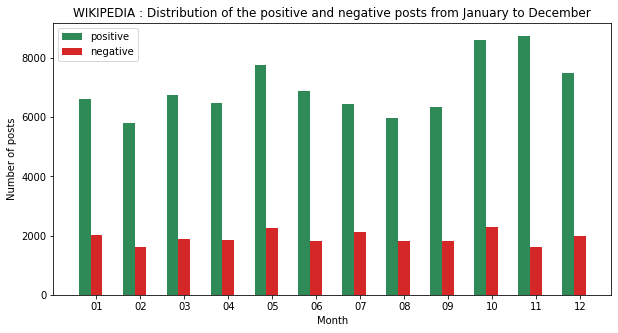

In [ ]:
# Grafical representation of the edges (+, -) distribution according to the month  
N = 12 # number of month 
ind = np.arange(N)  # the x locations for the groups
width = 0.27       # the width of the bars

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)

 
month_pos_wiki = wiki_pos.groupby(wiki_pos['Date'].dt.month).size()
rects1 = ax.bar(ind, month_pos_wiki, width, color='seagreen')
month_neg_wiki = wiki_neg.groupby(wiki_neg['Date'].dt.month).size()
rects2 = ax.bar(ind+width, month_neg_wiki, width, color='tab:red')

ax.set_ylabel('Number of posts')
ax.set_xlabel('Month')
ax.set_title('WIKIPEDIA : Distribution of the positive and negative posts from January to December')
ax.set_xticks(ind+width)
ax.set_xticklabels( ('01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12'))
ax.legend( (rects1[0], rects2[0]), ('positive', 'negative') )

plt.show()

**Analysis :**
- because of the "wave" profile, it is hard to see if pos and neg have the same trend
- it is also hard to say which month has the higher number of edges in total

We need to compute the ratio.

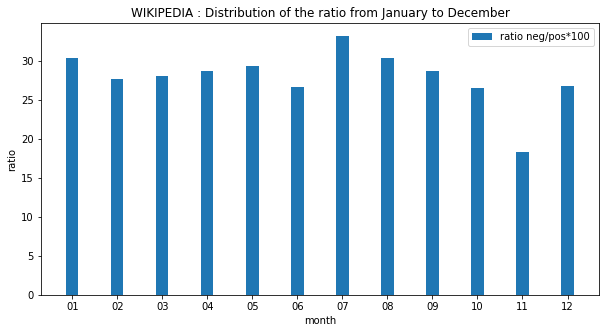

In [ ]:
# Grafical representation of the edges ratio(-/+*100) distribution according to the year 
ratio_w = [(int(b) / int(m))*100 for b,m in zip(month_neg_wiki, month_pos_wiki)]
N = 12 #number of months
ind = np.arange(N)  # the x locations for the groups
width = 0.27       # the width of the bars

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)


rects1 = ax.bar(ind, ratio_w, width, color='tab:blue', label = 'ratio neg/pos*100')
ax.set_ylabel('ratio')
ax.set_xlabel('month')
ax.set_title('WIKIPEDIA : Distribution of the ratio from January to December')
ax.set_xticks(ind)
ax.set_xticklabels( ('01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12'))
ax.legend()

plt.show()

**Analysis :**
- we can identify three parts : small ratio : month 11, high ratio : month 7, middle ratio : month 1-2-3-4-5-6-8-9-10-12
- As done previously, we have to find the more representative month for middle ratio

In [ ]:
# ratio middle
mean_middle_pos = statistics.mean([month_pos_wiki.iloc[0], month_pos_wiki.iloc[1], month_pos_wiki.iloc[2], month_pos_wiki.iloc[3], month_pos_wiki.iloc[4], month_pos_wiki.iloc[5], month_pos_wiki.iloc[7], month_pos_wiki.iloc[10], month_pos_wiki.iloc[11]])
print('The mean count of posts from jan. to apr. is ', mean_middle_pos)
print('The difference between number of counts and mean for march and april is respectively: \n',[abs(x - mean_middle_pos) for x in[month_pos_wiki.iloc[0], month_pos_wiki.iloc[1], month_pos_wiki.iloc[2], month_pos_wiki.iloc[3], month_pos_wiki.iloc[4], month_pos_wiki.iloc[5], month_pos_wiki.iloc[7], month_pos_wiki.iloc[10], month_pos_wiki.iloc[11]]])

The mean count of posts from jan. to apr. is  6950
The difference between number of counts and mean for march and april is respectively: 
 [340, 1135, 184, 473, 810, 57, 961, 1798, 544]


- more representative for the middle ratio is **june** (06) because the difference with the average value is the smaller. 

**Ccl :** In order to assess the impact of the **MONTH** on the structure of the network, we can compare  3 subgraphs : 
> - from novembre (11) (representative of the first group - low ratio < 20- )
> - from july (07) (representative of the second group, -high ratio > 30-)
> - from june (06) (representative of the third group, -middle ratio around 25-)

### Step 3 :  Analysis of the day 
Now we have a look on the day's trend. Here is presented the amount of positive and negatives edges according to the day of the month.

In [ ]:
day_positive_wiki = wiki_pos.groupby(wiki_pos['Date'].dt.day).size()
day_negative_wiki = wiki_neg.groupby(wiki_neg['Date'].dt.day).size()
print('Month Positive', day_positive_wiki)
print('Month Negative', day_negative_wiki)

Month Positive Date
1     3056
2     2906
3     2962
4     3107
5     3325
6     2930
7     2987
8     2934
9     2801
10    3194
11    2921
12    2772
13    2777
14    2790
15    2690
16    2643
17    2521
18    2509
19    2418
20    2569
21    2486
22    2686
23    2742
24    2754
25    2343
26    2504
27    2392
28    2669
29    2252
30    2479
31    1834
dtype: int64
Month Negative Date
1     845
2     915
3     851
4     825
5     789
6     860
7     800
8     808
9     842
10    795
11    701
12    693
13    761
14    621
15    608
16    732
17    667
18    699
19    634
20    643
21    726
22    763
23    854
24    755
25    650
26    672
27    696
28    733
29    839
30    781
31    560
dtype: int64


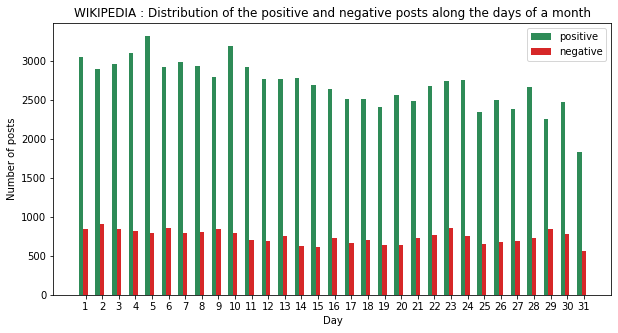

In [ ]:
# Grafical representation of the edges (+, -) distribution according to the day of the month 

N = 31#number of days in a month
ind = np.arange(N)  # the x locations for the groups
width = 0.27       # the width of the bars

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)

 
day_pos_wiki = wiki_pos.groupby(wiki_pos['Date'].dt.day).size()
rects1 = ax.bar(ind, day_pos_wiki, width, color='seagreen')
day_neg_wiki = wiki_neg.groupby(wiki_neg['Date'].dt.day).size()
rects2 = ax.bar(ind+width, day_neg_wiki, width, color='tab:red')

ax.set_ylabel('Number of posts')
ax.set_xlabel('Day')
ax.set_title('WIKIPEDIA : Distribution of the positive and negative posts along the days of a month')
ax.set_xticks(ind+width)
ax.set_xticklabels( ('1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26' ,'27', '28', '29', '30', '31'))
ax.legend((rects1[0], rects2[0]), ('positive', 'negative'))

plt.show()

**Analysis :**
- compared to all the other graph, color red very present, it means that the ratio will probably be higher with this observation according to the day of the month 
- the sudden decrease for 31 is, as for Reddit, due to the fact that this day is not present in every month of the year

We need to compute the ration to see overall trend

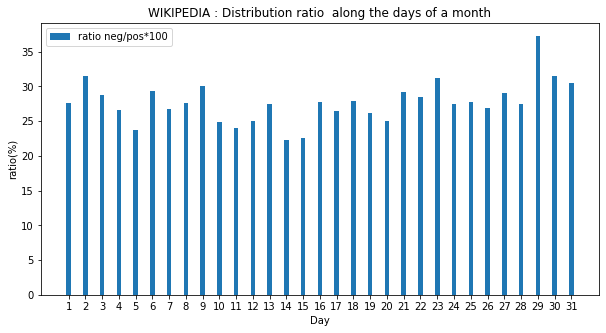

In [ ]:
# Grafical representation of the edges ratio(-/+*100) distribution according to the year 

ratio_w = [(int(b) / int(m))*100 for b,m in zip(day_neg_wiki, day_pos_wiki)]
N = 31
ind = np.arange(N)  # the x locations for the groups
width = 0.27       # the width of the bars

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)

rects1 = ax.bar(ind, ratio_w, width, color='tab:blue', label = 'ratio neg/pos*100')

ax.set_ylabel('ratio(%)')
ax.set_xlabel('Day')
ax.set_title('WIKIPEDIA : Distribution ratio  along the days of a month')
ax.set_xticks(ind)
ax.set_xticklabels( ('1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26' ,'27', '28', '29', '30', '31'))
ax.legend()
plt.show()

**Analysis :**
- as for Reddit, the approach look at the day in a month not very clear, and it appears quite hard and arbitrarly to define subgraphs from it.

So we focus on day of the week

#### Step 3 : cont. Analysis of the dat of the week

Here is presented the amount of positive and negative according to the day of the week. As for Reddit, 0 corresponds to monday and 6 to sunday.

In [ ]:
day_positive_wiki = wiki_pos.groupby(wiki_pos['Date'].dt.weekday).size()
day_negative_wiki = wiki_neg.groupby(wiki_neg['Date'].dt.weekday).size()
print('Month Positive', day_positive_wiki)
print('Month Negative', day_negative_wiki)

Month Positive Date
0    12181
1    13259
2    12409
3    12257
4    12252
5    11081
6    10514
dtype: int64
Month Negative Date
0    3203
1    3513
2    3353
3    3488
4    3602
5    2827
6    3132
dtype: int64


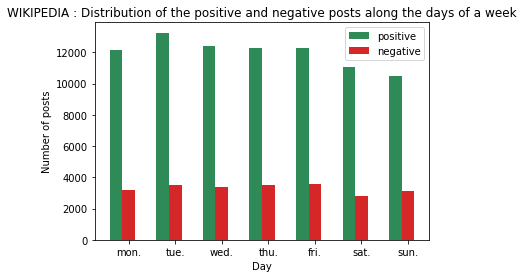

In [ ]:
# Grafical representation of the edges (+, -) distribution according to the day of the week 

N = 7 #number of days in a week
ind = np.arange(N)  # the x locations for the groups
width = 0.27       # the width of the bars

fig = plt.figure()
ax = fig.add_subplot(111)

 
dayw_pos_wiki = wiki_pos.groupby(wiki_pos['Date'].dt.weekday).size()
rects1 = ax.bar(ind, dayw_pos_wiki, width, color='seagreen')
dayw_neg_wiki = wiki_neg.groupby(wiki_neg['Date'].dt.weekday).size()
rects2 = ax.bar(ind+width, dayw_neg_wiki, width, color='tab:red')

ax.set_ylabel('Number of posts')
ax.set_xlabel('Day')
ax.set_title('WIKIPEDIA : Distribution of the positive and negative posts along the days of a week')
ax.set_xticks(ind+width)
ax.set_xticklabels( ('mon.', 'tue.', 'wed.', 'thu.', 'fri.', 'sat.', 'sun.'))
ax.legend((rects1[0], rects2[0]), ('positive', 'negative'))

plt.show()

**Analysis :**
- It is quite hard here to identify a global trend. It would be a guess, and that is not good. We could see a small decrease for the amount of positive edges along the week but it is hard to see anything for the negative ones
- negative are, like for the day of the month, quite a lot present compared to other graphs

So we have to compute the ratio.


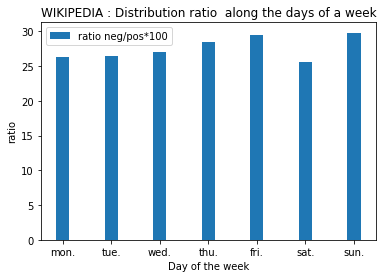

In [ ]:
# Grafical representation of the edges ratio (-/+*100) distribution according to the day of the week 

ratio_w = [(int(b) / int(m))*100 for b,m in zip(dayw_neg_wiki, dayw_pos_wiki)]
N = 7
ind = np.arange(N)  # the x locations for the groups
width = 0.27       # the width of the bars

fig = plt.figure()
ax = fig.add_subplot(111)

rects1 = ax.bar(ind, ratio_w, width, color='tab:blue', label = 'ratio neg/pos*100')

ax.set_ylabel('ratio')
ax.set_xlabel('Day of the week')
ax.set_title('WIKIPEDIA : Distribution ratio  along the days of a week')
ax.set_xticks(ind)
ax.set_xticklabels( ('mon.', 'tue.', 'wed.', 'thu.', 'fri.', 'sat.', 'sun.'))
ax.legend()
plt.show()

**Analysis :**
- increase of the ratio during the work week (monday to friday) and difference from saturday to sunday. Saturday looks like the beginning of the week while sunday looks like friday

So we will focus on the extrem : monday and friday

**Ccl :** In order to assess the impact of the **Day** on the structure of the network, we can compare  2 subgraphs : 
> - from monday 
> - from friday

### Step 4 : Analysis of the hour 

Here are presented the amount of positive and negative edges according to the hour of the day. Convention 00 is mid-night.

In [ ]:
hour_positive_wiki = wiki_pos.groupby(wiki_pos['Date'].dt.hour).size()
hour_negative_wiki = wiki_neg.groupby(wiki_neg['Date'].dt.hour).size()
print('Month Positive', hour_positive_wiki)
print('Month Negative', hour_negative_wiki)

Month Positive Date
0     4784
1     4417
2     4196
3     3879
4     3597
5     3196
6     2821
7     2507
8     2400
9     2073
10    2290
11    2421
12    2539
13    2877
14    3215
15    3585
16    3784
17    3978
18    4067
19    3939
20    4144
21    4574
22    4313
23    4357
dtype: int64
Month Negative Date
0     1273
1     1173
2     1149
3     1081
4      952
5      913
6      767
7      713
8      595
9      544
10     555
11     548
12     686
13     778
14     887
15    1040
16    1047
17    1157
18    1183
19    1093
20    1175
21    1270
22    1302
23    1237
dtype: int64


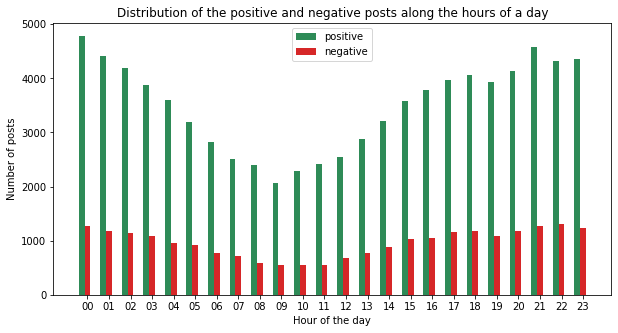

In [ ]:
# Grafical representation of the edges (+, -) distribution according to the hour of the day 

N = 24
ind = np.arange(N)  # the x locations for the groups
width = 0.27       # the width of the bars

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)

hour_pos_wiki = wiki_pos.groupby(wiki_pos['Date'].dt.hour).size()
rects1 = ax.bar(ind, hour_pos_wiki, width, color='seagreen')
hour_neg_wiki = wiki_neg.groupby(wiki_neg['Date'].dt.hour).size()
rects2 = ax.bar(ind+width, hour_neg_wiki, width, color='tab:red')

ax.set_ylabel('Number of posts')
ax.set_xlabel('Hour of the day')
ax.set_title('Distribution of the positive and negative posts along the hours of a day')
ax.set_xticks(ind+width)
ax.set_xticklabels(('00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23'))
ax.legend((rects1[0], rects2[0]), ('positive', 'negative'))

plt.show()

**Analysis :**
- crazy trend :) It appears to be the reverse ot the Reddit one.
- It is to have very lot edges (both positive and negative) at morning - mid day then during night ... (may be due to some jetlag somehow? should do an analysis on geographic caracteristics of the node -which we don't have- to check)
- both positive and negative seams to have the same trend, but positive seams to be more marked. 

We need to compute the ratio to check.

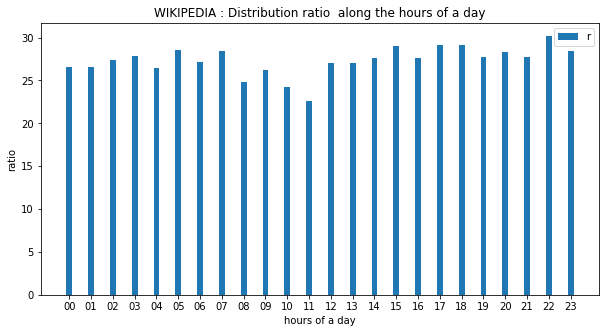

In [ ]:
# Grafical representation of the edges ratio (-/+*100) distribution according to the year 

ratio_ww = [(int(b) / int(m))*100 for b,m in zip(hour_neg_wiki, hour_pos_wiki)]
N = 24
ind = np.arange(N)  # the x locations for the groups
width = 0.27       # the width of the bars

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)

rects1 = ax.bar(ind, ratio_ww, width, color='tab:blue')

ax.set_ylabel('ratio')
ax.set_xlabel('hours of a day')
ax.set_title('WIKIPEDIA : Distribution ratio  along the hours of a day')
ax.set_xticks(ind)
ax.set_xticklabels(('00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23'))
ax.legend('ratio')
plt.show()

**Analysis :**
- kind of loosing the previous trend : so both positve and negative where behaving quite similar
- here 2 parts : low ratio (around morning : 8, 10, 11 and then middle one (00, 01, 02, 03, 04, 05, 06, 07, 09, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23)

So we need to find the hour the more relevent for the both parts.

In [ ]:
# ratio low 
mean_rlow_pos = statistics.mean([hour_pos.iloc[8], hour_pos.iloc[10], hour_pos.iloc[11]])
print('The mean count of posts from jan. to apr. is ', mean_rlow_pos)
print('The difference between number of counts and mean for march and april is respectively: \n',[abs(x - mean_rlow_pos) for x in[hour_pos.iloc[8], hour_pos.iloc[10], hour_pos.iloc[11]]])


The mean count of posts from jan. to apr. is  14149
The difference between number of counts and mean for march and april is respectively: 
 [777, 40, 738]


- **10h** is representative of low ratio

In [ ]:
# ratio middle 
mean_rmiddle_pos = statistics.mean([hour_pos.iloc[0], hour_pos.iloc[1], hour_pos.iloc[2], hour_pos.iloc[3], hour_pos.iloc[4], hour_pos.iloc[5], hour_pos.iloc[6], hour_pos.iloc[7], hour_pos.iloc[9], hour_pos.iloc[12], hour_pos.iloc[13], hour_pos.iloc[14], hour_pos.iloc[15], hour_pos.iloc[16], hour_pos.iloc[17], hour_pos.iloc[18], hour_pos.iloc[19], hour_pos.iloc[20], hour_pos.iloc[21], hour_pos.iloc[22], hour_pos.iloc[23]])
print('The mean count of posts from jan. to apr. is ', mean_rmiddle_pos)
print('The difference between number of counts and mean for march and april is respectively: \n',[abs(x - mean_rmiddle_pos) for x in[hour_pos.iloc[0], hour_pos.iloc[1], hour_pos.iloc[2], hour_pos.iloc[3], hour_pos.iloc[4], hour_pos.iloc[5], hour_pos.iloc[6], hour_pos.iloc[7], hour_pos.iloc[9], hour_pos.iloc[12], hour_pos.iloc[13], hour_pos.iloc[14], hour_pos.iloc[15], hour_pos.iloc[16], hour_pos.iloc[17], hour_pos.iloc[18], hour_pos.iloc[19], hour_pos.iloc[20], hour_pos.iloc[21], hour_pos.iloc[22], hour_pos.iloc[23]]])


The mean count of posts from jan. to apr. is  10621
The difference between number of counts and mean for march and april is respectively: 
 [3532, 4576, 4987, 4521, 3754, 2802, 683, 1448, 3805, 3950, 3996, 4373, 3528, 2646, 2546, 1797, 1268, 304, 721, 1687, 2396]


- **6h** is representative of the middle ratio

**Ccl :** In order to assess the impact of the **hour** on the structure of the network, we can compare  2 subgraphs : 
> - from 10h : low ratio
> - from 6h : middle ratio

### 2.1.2.2] Structural analysis on wikipedia subgraphs

Then let’s have a look on the wikipedia dataset.

#### Wikipedia - Year 

Three subgraphs have been computed from this dataset according to the year global trend. 
- One from 2005, representing the ratio 15-20 group,
- one from 2007 representing the 25-30 ratio group 
- one from 2008 representing the 20-25 ratio group.

Here are presented the parameters for the centrality analysis : so degree, closeness, local clustering coefficient and of course centrality degree. As these parameters are calculated for a single node, we are presenting here the min, max and average in the total network.

In [ ]:
Wiki_votes

,FromNodeId,ToNodeId,Sign,Date,Votes
0,3,30,1,2004-09-14 16:26:00,23
1,25,30,-1,2004-09-14 16:53:00,100
2,4,30,1,2004-09-14 17:08:00,32
3,5,30,1,2004-09-14 17:37:00,23
4,6,30,1,2004-09-14 19:28:00,317
...,...,...,...,...,...
107075,8045,6307,-1,2008-01-05 23:34:00,7
107076,7053,6307,-1,2008-01-05 23:36:00,32
107077,6885,6307,-1,2008-01-06 00:44:00,19
107078,8243,6307,-1,2008-01-06 01:07:00,6


In [ ]:
mask_2005 = (Wiki_votes['Date'] > '2005-1-1') & (Wiki_votes['Date'] <= '2005-12-31')
mask_2007 = (Wiki_votes['Date'] > '2007-1-1') & (Wiki_votes['Date'] <= '2007-12-31')
mask_2008 = (Wiki_votes['Date'] > '2008-1-1') & (Wiki_votes['Date'] <= '2008-12-31')

wikipedia_2005 = Wiki_votes.loc[mask_2005]
wikipedia_2007 = Wiki_votes.loc[mask_2007]
wikipedia_2008 = Wiki_votes.loc[mask_2008]

In [ ]:
wikipedia_2007.head()

,FromNodeId,ToNodeId,Sign,Date,Votes
3370,625,624,1,2007-02-20 00:47:00,3
7091,1004,789,1,2007-04-12 23:16:00,13
33734,3194,3195,-1,2007-08-14 16:01:00,1
33943,3224,2237,-1,2007-07-10 13:06:00,1
42745,3794,3797,1,2007-01-06 21:49:00,48


In [ ]:
wikipedia_2005.head()

,FromNodeId,ToNodeId,Sign,Date,Votes
404,165,167,-1,2005-01-31 13:01:00,3
1149,304,322,1,2005-05-24 20:28:00,81
1150,72,322,1,2005-05-24 20:39:00,181
1151,94,322,-1,2005-05-24 21:20:00,89
1152,25,322,-1,2005-05-24 21:59:00,100


In [ ]:
wikipedia_2005_graph = nx.from_pandas_edgelist(wikipedia_2005,"FromNodeId","ToNodeId",edge_attr="Sign",create_using=nx.DiGraph)
wikipedia_2008_graph = nx.from_pandas_edgelist(wikipedia_2008,"FromNodeId","ToNodeId",edge_attr="Sign",create_using=nx.DiGraph)
wikipedia_2007_graph = nx.from_pandas_edgelist(wikipedia_2007,"FromNodeId","ToNodeId",edge_attr="Sign",create_using=nx.DiGraph)
wikipedia_2005_table1,wikipedia_2005_table2 = graph_properties(wikipedia_2005_graph)
wikipedia_2007_table1,wikipedia_2007_table2 = graph_properties(wikipedia_2007_graph)
wikipedia_2008_table1,wikipedia_2008_table2 = graph_properties(wikipedia_2008_graph)

In [ ]:
wikipedia_2005_table1

,Average,Max,Min
Degree,20.407061,422.000000,1.000000
Closeness,0.067255,0.304447,0.000000
Local clustering coefficient,0.078754,1.000000,0.000000
Centrality,0.010601,0.219221,0.000519


In [ ]:
wikipedia_2007_table1

,Average,Max,Min
Degree,21.853923,533.000000,1.000000
Closeness,0.057548,0.316734,0.000000
Local clustering coefficient,0.074431,1.000000,0.000000
Centrality,0.005935,0.144758,0.000272


In [ ]:
wikipedia_2008_table1

,Average,Max,Min
Degree,4.291667,114.000000,1.000000
Closeness,0.010002,0.413115,0.000000
Local clustering coefficient,0.062715,1.000000,0.000000
Centrality,0.014954,0.397213,0.003484


**Centrality analysis :**
- First 2005 and 2007 have pretty similar average node degrees while 2008 have a very smaller one. All the three have a minimum node degree of 1 which means that there is no isolated node. 
- However both 2005 and 2008 have a similar average centrality value, while 2007 has a very lower one (factor 2). This means that there is a dissymmetry in the network structure between the years. A high average degree means that nodes tend to have a lot of incoming edges, and a high value of centrality means that nodes tend to have a high number of connections (in total both incoming and outgoing).So in the case of 2008, the high average centrality means a lot of connection per for each node. The quite low average degree is pretty surprising but could mean a disequilibrium of the sent and received number of edges, and thus could give information to node's acitivty.

- we can see that the closeness average is 6 or 5 times smaller for 2008 than for 2005 and 2007. A small average closeness indicates an important average distance between a node with all the nodes. This could mean that the nodes tend to be linked to more distant ones. 

- All the subgraphs seem to have the same local clustering coefficient, and thus neighbors of a random node seem to be equally connected.

-----------


Now let’s have a look at the behaviour and clustering analysis. 


In [ ]:
wikipedia_2005_table2

,
Global clustering coefficient,0.062375
Assortativity degree,-0.110852


In [ ]:
wikipedia_2007_table2

,
Global clustering coefficient,0.061274
Assortativity degree,-0.153825


In [ ]:
wikipedia_2008_table2

,
Global clustering coefficient,0.120192
Assortativity degree,-0.178545


**Clustering and Behavior analysis :**
- First we can see that the global clustering coefficient is the highest for 2008, compared to 2007 which is itself higher than 2005. This is in accordance with our previous observations about the high connectivity of this network.  We could also interpret this high global clustering coefficient as a bigger probability to have an edge between two nodes with a common neighbor, because its means a higher proportion of triangles in the graph.
- For the assortativity degree, we do not see a particular trend along the 3 years. 

Here we are able to see changes in the network structure according to the year, especially concerning the clustering. In fact the year 2008 appears to be more tightly connected than the 2005 and 2007. It is quite important to notice this in the context of votation because it changes the possible consequences of an event at one part of the network on the final output. As population mass manipulation if you are nominated, it is very important to know this in order to assess the impact of your choice of campaign.
These results are not aberrant in our connected world, where everyone tends to be more and more connected, even to people away (geographically, socially, culturally).
However, these results are not obvious and further computation should be done. Here it is just an highlighting of the possible impact on the structure, to raise conscientiousness about this variable.

-----

#### Wikipedia - Month

So now we are considering time trends according to the month. 

As a reminder, we splitted the data according to 3 ratio neg/pos edges different. 
- The first part is from november and represent the group with low ratio (not a lot of neg edges), 
- the second part is from june and represent the group with middle ratio (quite the same amount of  pos and neg edges) 
- the third one is from july and represent the group with a high ratio (quite a lot  of negative edges).


In [ ]:
mask_nov = (Wiki_votes['Date'].dt.month == 11)
mask_july = (Wiki_votes['Date'].dt.month == 7)
mask_june = (Wiki_votes['Date'].dt.month == 6)

wikipedia_nov = Wiki_votes.loc[mask_nov]
wikipedia_july = Wiki_votes.loc[mask_july]
wikipedia_june = Wiki_votes.loc[mask_june]

In [ ]:
wikipedia_july.head(20000)

,FromNodeId,ToNodeId,Sign,Date,Votes
2106,453,192,1,2004-07-11 00:23:00,1
2107,18,192,-1,2004-07-11 00:37:00,12
2108,101,192,-1,2004-07-11 00:38:00,17
2109,352,192,-1,2004-07-11 00:43:00,9
2110,56,192,1,2004-07-11 00:46:00,24
...,...,...,...,...,...
90764,1549,5288,1,2007-07-31 22:45:00,629
90765,4795,5288,1,2007-07-31 22:53:00,76
90766,4455,5288,1,2007-07-31 23:23:00,22
90767,737,5288,1,2007-07-31 23:41:00,251


In [ ]:
wikipedia_nov_graph = nx.from_pandas_edgelist(wikipedia_nov,"FromNodeId","ToNodeId",edge_attr="Sign",create_using=nx.DiGraph)
wikipedia_july_graph = nx.from_pandas_edgelist(wikipedia_july,"FromNodeId","ToNodeId",edge_attr="Sign",create_using=nx.DiGraph)
wikipedia_june_graph = nx.from_pandas_edgelist(wikipedia_june,"FromNodeId","ToNodeId",edge_attr="Sign",create_using=nx.DiGraph)
wikipedia_nov_table1,wikipedia_nov_table2 = graph_properties(wikipedia_nov_graph)
wikipedia_july_table1,wikipedia_july_table2 = graph_properties(wikipedia_july_graph)
wikipedia_june_table1,wikipedia_june_table2 = graph_properties(wikipedia_june_graph)

In [ ]:
wikipedia_nov_table1

,Average,Max,Min
Degree,10.051506,189.000000,1.000000
Closeness,0.016710,0.253044,0.000000
Local clustering coefficient,0.058889,1.000000,0.000000
Centrality,0.004886,0.091881,0.000486


In [ ]:
wikipedia_july_table1

,Average,Max,Min
Degree,9.592821,244.000000,1.000000
Closeness,0.021830,0.287275,0.000000
Local clustering coefficient,0.086298,1.000000,0.000000
Centrality,0.005383,0.136925,0.000561


In [ ]:
wikipedia_june_table1

,Average,Max,Min
Degree,10.283019,186.000000,1.00000
Closeness,0.018842,0.234398,0.00000
Local clustering coefficient,0.078658,1.000000,0.00000
Centrality,0.006067,0.109735,0.00059


**Centrality analysis :**

Here are presented the results for centrality parameters. We can see : 
- The average degree value is quite the same for all the 3 months 
- The closeness average value is also quite constant among the 3 months 
- The local clustering coefficient is rising according to the proportion of negative edges. This means that it is small in november, higher in june and even higher in july (which has the biggest ratio). Even if it is hard to do a guess about why do we see a such trend, the arrival of the summer and holidays may have a link with people's activity and thus their amount of connections to each other. In fact a higher local clustering coefficient means that the removal of a given node will have less impact on the ability of communication of influence of its neighbor. It is quite important to notice that during votation process because it means on the other side that during winter (e.g. november), node’s communication/influence are more dependant to each other and thus individual position-taking can have a big consequences, and its nature -an opposite leader or a supporter- may become important.
- The centrality coefficient is a bit higher in june compared to other ones, but as for the closeness, the difference may not be big enough to allow any conclusions

------

Now let’s have a look at the clustering and behavior parameters

In [ ]:
wikipedia_nov_table2

,
Global clustering coefficient,0.061379
Assortativity degree,-0.078402


In [ ]:
wikipedia_june_table2

,
Global clustering coefficient,0.093659
Assortativity degree,-0.059507


In [ ]:
wikipedia_july_table2

,
Global clustering coefficient,0.098919
Assortativity degree,-0.100510


**Clustering and Behavior analysis :**
- The global clustering coefficient is higher in summer (june - july) than in winter (november). It means that nodes tend to create more close triangles during summer than winter. As the local clustering coefficient, this trend may be explained by the atmosphere of the summer, and the rise of activating associated. What we can say is that the summer months present a network more connected. 
- The assortativity doesn't have a very clear global trend. We can only say that July is the closest one to zero, which means that it tends to be more non-assortative and November and even more July tend to be more disassortative. It is quite hard to explain these observations. 


It is quite hard to explain all the trends, sometimes quite small or illogical but here it is not our goal. However these observations and understanding could be important in a votation process because as we have seen that may have an impact on the global structure of the network. With the local clustering coefficient, we have seen that the network tends to be more influenceable in winter than in summer, thus political calculations may take it into account. Also it appears that the summer network tends to be more connected, so with more closed triangles than in winter. Thus people are more connected and as they are influencing each other, the strategy of communication of a candidate may change (could focus on a group of people, because they tend to be more connected than patchy ones in the winter where it would be more difficult to talk to a group). Finally, even if the trend is not very logical, assortativity may give important information on the network structure. November and July seem to be more diss-assortative, thus it means that links between nodes are not very similar. So for a candidate talking to a group, it is important to have conscious of this, an adapt its speech : it would be perhaps more nuanced than if all people were similar, because its aim is to gather as many people as possible, so not to offend/ hurt or shock any part of the listening assembly.

------

#### Wikipedia - Day 
As a reminder, we have created 2 subgraphs according to the trend observed along the week. We have seen that the ratio neg/pos is becoming more important along the workweek, and that during the week-end, saturday looks like monday and sunday looks like friday. With very basic psychology, one interpretation would be that along the week people are getting more and more tired and are generally fed up. On saturday it is the beginning of the weekend, so people are more happy and then tend to vote less negatively, while on sunday it is the end of the weekend, so people are sad and annoyed by the situation. This try of explanation is based on the idea that people’s mood influences the vote. To be more precise in the analysis of trend’s observations we would need to go further in social analysis/explanation, but we are not competent here. Anyway, this trial of explanation can give an idea. 

So here we have chosen to build a subgraph from votes 
- on monday, representing the low ratio of the beginning of the week (and saturday, people happy?),
- one from friday, representing the end of workweek and sunday (people fed up?). 


In [8]:
mask_monday = (Wiki_votes['Date'].dt.weekday == 0)
mask_friday = (Wiki_votes['Date'].dt.weekday == 4)

wikipedia_monday = Wiki_votes.loc[mask_monday]
wikipedia_friday = Wiki_votes.loc[mask_friday]

In [9]:
wikipedia_monday_graph = nx.from_pandas_edgelist(wikipedia_monday,"FromNodeId","ToNodeId",edge_attr="Sign",create_using=nx.DiGraph)
wikipedia_friday_graph = nx.from_pandas_edgelist(wikipedia_friday,"FromNodeId","ToNodeId",edge_attr="Sign",create_using=nx.DiGraph)


wikipedia_monday_table1,wikipedia_monday_table2 = graph_properties(wikipedia_monday_graph)
wikipedia_friday_table1,wikipedia_friday_table2= graph_properties(wikipedia_friday_graph)

In [ ]:
wikipedia_monday_table1

,Average,Max,Min
Degree,8.846087,166.000000,1.000000
Closeness,0.047316,0.179846,0.000000
Local clustering coefficient,0.017640,1.000000,0.000000
Centrality,0.002555,0.047949,0.000289


In [ ]:
wikipedia_friday_table1

,Average,Max,Min
Degree,8.909245,233.000000,1.000000
Closeness,0.047259,0.197214,0.000000
Local clustering coefficient,0.019541,0.500000,0.000000
Centrality,0.002520,0.065894,0.000283


**Centrality analysis :**
- Friday appears to have a higher average degree and local clustering coefficient
- monday appears to have a higher closeness and centrality

However the difference are really small and thus may not be statistically significant. Neverless what we can notice is taht the spread out of node degree is much more important for friday than monday, with a higher maximum value.

----------

In [10]:
wikipedia_monday_table2

,
Global clustering coefficient,0.017420
Assortativity degree,-0.015305


In [11]:
wikipedia_friday_table2

,
Global clustering coefficient,0.019813
Assortativity degree,-0.012944


**Clustering and Behavior analysis :**
- global clustering coefficient higher in friday
- assortativity degree closer to zero in friday

What we may say that friday appreas to be more tighly connected than monday. However due to the very small difference observed it is hard to truly conclude something and we may need deeper analysis involving other paramters. 
So with what we have, we may say that day of the week may impact a little bit the connectivity of the network. 

-----

#### Wikipedia - Hour

Now we focus on the hour of the day. After plotting the ratio of neg/pos edges according to the hour of the day, we were able to identify 2 groups. We have drawn : 
- a first subgraph from 10h, representing the group with low ratio, 
- a second one from 6h representative from the high ratio. 

As we were able to see on the graph of the ratio, lower one corresponds to the mid-day period, while higher one corresponds to the afternoon/night and morning period. One could understand it during the lunch break, people tend to be more happy and thus vote less negatively. Of course it is only an hypothesis, but it can give an idea. 
Let’s have a look at the centrality parameters. 

In [ ]:
mask_10h = (Wiki_votes['Date'].dt.hour == 10)
mask_6h = (Wiki_votes['Date'].dt.hour == 6)

wikipedia_10h = Wiki_votes.loc[mask_10h]
wikipedia_6h = Wiki_votes.loc[mask_6h]

In [ ]:
wikipedia_6h.head()

,FromNodeId,ToNodeId,Sign,Date,Votes
10,12,30,1,2004-09-15 06:56:00,74
68,11,61,1,2004-09-12 06:21:00,791
84,27,6,1,2004-09-11 06:13:00,104
85,11,6,1,2004-09-11 06:50:00,791
128,12,8,-1,2004-09-15 06:38:00,74


In [ ]:
wikipedia_10h.head()

,FromNodeId,ToNodeId,Sign,Date,Votes
50,47,54,1,2004-09-16 10:28:00,158
51,48,54,1,2004-09-16 10:39:00,22
55,50,54,1,2004-09-17 10:47:00,14
75,14,61,1,2004-09-13 10:22:00,121
137,45,8,-1,2004-09-16 10:08:00,9


In [ ]:
wikipedia_10h_graph = nx.from_pandas_edgelist(wikipedia_10h,"FromNodeId","ToNodeId",edge_attr="Sign",create_using=nx.DiGraph)
wikipedia_6h_graph = nx.from_pandas_edgelist(wikipedia_6h,"FromNodeId","ToNodeId",edge_attr="Sign",create_using=nx.DiGraph)


wikipedia_10h_table1,wikipedia_10h_table2 = graph_properties(wikipedia_10h_graph)
wikipedia_6h_table1,wikipedia_6h_table2 = graph_properties(wikipedia_6h_graph)

In [ ]:
wikipedia_10h_table1

,Average,Max,Min
Degree,3.057558,82.000000,1.000000
Closeness,0.002978,0.027898,0.000000
Local clustering coefficient,0.005650,0.500000,0.000000
Centrality,0.001646,0.044133,0.000538


In [ ]:
wikipedia_6h_table1

,Average,Max,Min
Degree,3.427887,63.000000,1.000000
Closeness,0.005022,0.036394,0.000000
Local clustering coefficient,0.004731,0.500000,0.000000
Centrality,0.001643,0.030201,0.000479


**Centrality analysis :**
- The degree and closeness is higher for 6h than 10h : in the morning/afternoon may be more edge-sensitize (affected quickly for an event on another part of the network) than at mid-day
- local clustering coefficient and entrality values are quite the same for both sub-graphs.

For now we can say that both subgraphs are quite similar according to centrality parameters. Let’s have a look at behavior and clustering ones. 


------

In [ ]:
wikipedia_10h_table2

,
Global clustering coefficient,0.002137
Assortativity degree,-0.099332


In [ ]:
wikipedia_6h_table2

,
Global clustering coefficient,0.002967
Assortativity degree,-0.088337


**Behavior and clustering analysis**:

- Both global clustering and assortativity values are really similar for 6 and 10h. There is a slight increase in global clustering coefficient for 6h and a small diminution of assortativity degree. That may mean that the nodes are less aggregated to similar ones and that they tend to form more triangles. Thus the network at 6h would be more connected, and with more heterogeneous groups than at 10h. 

However these differences are so small that we would need further analysis to be able to assess this conclusion. Here it is just to raise curiosity about this trend, and there is a cue that something could be impacted.

So here we have analysed the possible impact of the hour on the voting network structure of wikipedia. As we were able to see comparing the different parameters between the 6h and 10h subgraphs, the differences are very very small. However one could say it reveals dissimmetry in network structure according to the hour of the day. Because the difference are small we have to be more careful about conclusions here, and add nuances to our possible extrapolations.

We had to do this analysis to carefully say this. However, further analysis is needed to properly exclude this variable from the group of network structure influencing ones.



<b> Wikipedia conclusion </b>

So here we have tried to analysis the impact of timestamp data associated to the edges on the network structure of the *wikipedia dataset*. We present a small recap of the conclusions drawn from the analysis of year, month, day and hours variables impact on the network structure parameters :

- Year : it appears that the year 2008 is more tighly connected than the 2 others 2004-7. The difference in  average degree and centrality shows a structure dissimmetry between incoming and outcoming edges between the different years. 2008 has a lower average degree but the same centrality as 2005, thus it could mean that 2008's node tend to be more active than the other subsets. The smaller closeness in 2008 may indicates connections with further people in average and its important clustering coefficient may show a high connectivity. *So year appears to have quite an important impact on the network structure, specially on centrality and clustering parameters*.

- Month : it appears that the local clustering coefficient is raising in accordance with the proportion of negative edges (and thus the ratio).  So in a month with a high ratio (as july), the removal a of given node will have less important impact on the ability of its neighbors to communicate and influence each others. This parameter is very important because it is an index of the dependancy of the node to each other. *So month appears to have an important and strategy influence on the network structure, specially for node's dependancy*.

- Day : Differences in parameters for day's subgraphs were pretty small and thus harder to analyse. Neverless we could say that Friday appears to be more connected  than monday due to the higher global clustering coefficient, and also less heterogeneous as its assortativity average is closer to zero. However we need further network structure analysis with other parameters to go deeper in the analysis.

- Hour : it appears that the centrality is higher is sub-graph from higher ratio, at least for degree and closeness parameters. This may means that for 6h, the nodes tends to less agregate with similar ones and have more connections. However, as for the day, the small difference do not allow to properly concluse and we may need further analysis with other parameters to deeply assess the impact of the hour on network structure.

So as a resume, year and month appear to impact quite a lot the structure while day and hour semas to less affect it.

Thus, in the context of wikipedia dataset, one can say that it might be very important to take Time variable and more specifically year and month into account when analysing network structure. As the edges represent votes, it might be very interesting to adapt the communication strategy of a canditate according to the network structure and thus the time of the election.

Let's draw a small sketch to show how time could impact the election. If we have a situation with 3 nodes A, B and C. A positively links to B anf B positively link to C. We are considering the edge between A and C. In the case of the balance theory, the edge A-C is more likely to be positive because the triad +++ is more plausible than ++-. On the other hand, according to the status theory, the link from C to A is more likely to be negative, as A will have a lower status from C's point of view. Now if we consider the time. Imagine that you are in 2005, we know that its ratio of negative versus positive edges is the lowest one. Thus the probability that the AC edge is negative is pretty lower compared to the same probability in 2008, when the ratio is higher. Now transport yourself in 2008. We have seen that the network seems to be more tightly connected, with high global clustering coefficient. So the probability that an edge effectively exists between A and C is higher than if you were in 2005-7. Also the dissymmetry in incoming-outcoming edges indicates a more important activity of the nodes. Thus the situation can rapidly change, and the nodes are influenced a lot by all their neighbors. So it would appear a bit restraint to consider only the node B in order to study the link between A and C, as it might be influence by other common neighbors (appears to likely be numerous in 2008). Now take a step back and imagine you are in july (whatever the year). There the ratio of negative versus positive edge is the highest of the year, so the probability that the edge AC is negative is very important compared to another month, i.e. novembre where the ratio is low. Also in July the nodes are more independent to each other. So the possible neighbors of C, other than only A and B might have less influence on C and thus on edge C-A. However if you are now in november,  nodes are more dependant to each other. So the removal of a common neighbor from C and B (not A) might have an important impact on their ability to communicate, thus it could finally impact the C-A edge. It is just a theoretical example, to try to highlight the importance that year and month may have in structure network analysis. As communication strategy is a key point in politics, knowing the way the network is structured is an undeniable advantage and can be critical strategically.

-----

<b>Time analysis final conclusion:</b>

From the work done and presented here, we were able to see different things. In a general manner we can conclude that time variables can affect in the network structure in different ways and thus might be taken into account during the analysis. Here we present 3 key points to remember from this analysis.
 
1) One can say that the importance of time variable depend on the dataset. So inside a unique dataset, year, month, day and hour can have different importance on the edges distribution and structure network. Here we have investigated the ratio of negative versus positive edges to draw our sub-graphs according to overall trend. Another way of thinking might be to base the dataset splitting according to the total amount of edge. So for example one could say that year and month appear to have very small effect on Reddit network structure while day and hour could affect its structure parameters.

2) One can say that the importance of time variables are different from one dataset to another. We have seen that both month and year appear to impact connectivity of Wikipedia network structure while it doesn't have effect on the Reddit one. On the other hand, Day and Hour seem to be irrelevant for the Wikipedia network structure while it could impact the Reddit one.

Thus we cannot say a general rule about time variables that must be taken into account when performing network structure analysis. We cannot universally withdraw variables and extrapolate the conclusions done on Reddit and Wikipedia datasets, because first, they are contradictory and second, they reveal the importance of doing the time analysis on the graph of interest to identify relevant time variables.

Finally we have seen that the global trend identified for each of the variables are very different according to the dataset. It seams logic as the two datasets are coming from two different website and nodes-edges don't represent the same things. However it is important to keep in mind that a prior social-historic analysis of the situation associated with the dataset or website might be very useful in the understanding of the trend and thus the analysis after. So at the first point, one might do a global trend analysis on its dataset to identify the subgraphs he will look into. We don't have general rules to split the dataset as it depends on its nature.

However here our goal is to use the pipeline to assess balance and status theory built in the paper to another dataset, to experience it. In that way it will allow us maybe to nuance the conclusion of the study under the light of our own conclusions with Reddit dataset.

# 5) Weights 


In this section, we will be grouping the data in weights from the data set. This is done to see if we can find any parameters giving a trend for the properties of the graph. 

The subgraph will be looked at to have significantly different from each other, in terms of weights. It will also be taken to account the subgraph will represent a large enough data set to do the analyze. In total three different subgraphs for every data set will be created. One with low values another with middle values and lastly one with high values. 

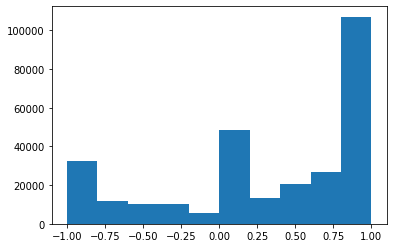

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure()
plt.hist(data_body['Sentiment'].tolist())
plt.show()

Out of the information about the distribution in the histogram, three subgraphs will be formed for further analyses. These three will represent one with a low sentiment score, mean sentiment score, and high sentiment score. 

By looking at the histogram we can see that a large number of the post have a score between -1.00 and -0.875, thus this will represent the subgraph with a low sentiment score. At the same time, one can see a large number of posts with a sentiment score between 0 and 0.125. That will represent the middle number. Lastly one can see that the score between 0.875 and 1 includes a very large number of posts, therefore this will be used as representing the subgraph with a high score. 



In [ ]:
mask_low_sentiment = (data_body['Sentiment'] >= -1) & (data_body['Sentiment'] <= -0.875)
mask_middle_sentiment = (data_body['Sentiment'] >= 0) & (data_body['Sentiment'] <= 0.125)
mask_high_sentiment = (data_body['Sentiment'] <= 1) & (data_body['Sentiment'] >= 0.875)

reddit_low_sentiment = data_body.loc[mask_low_sentiment]
reddit_middle_sentiment = data_body.loc[mask_middle_sentiment]
reddit_high_sentiment = data_body.loc[mask_high_sentiment]

In [ ]:
reddit_low_sentiment_graph = nx.from_pandas_edgelist(reddit_low_sentiment,"SOURCE_SUBREDDIT","TARGET_SUBREDDIT",edge_attr="Sign",create_using=nx.DiGraph)
reddit_middle_sentiment_graph= nx.from_pandas_edgelist(reddit_middle_sentiment,"SOURCE_SUBREDDIT","TARGET_SUBREDDIT",edge_attr="Sign",create_using=nx.DiGraph)
reddit_high_sentiment_graph= nx.from_pandas_edgelist(reddit_high_sentiment,"SOURCE_SUBREDDIT","TARGET_SUBREDDIT",edge_attr="Sign",create_using=nx.DiGraph)


In [ ]:
reddit_low_sentiment_table1,reddit_low_sentiment_table2 = graph_properties(reddit_low_sentiment_graph) 
reddit_middle_sentiment_table1,reddit_middle_sentiment_table2 = graph_properties(reddit_middle_sentiment_graph) 
reddit_high_sentiment_table1,reddit_high_sentiment_table2 = graph_properties(reddit_high_sentiment_graph) 

In [ ]:
reddit_low_sentiment_table1

,Average,Max,Min
Degree,4.594022,609.000000,1.000000
Closeness,0.045287,0.180528,0.000000
Local clustering coefficient,0.073576,1.000000,0.000000
Centrality,0.000616,0.081635,0.000134


In [ ]:
reddit_middle_sentiment_table1

,Average,Max,Min
Degree,4.276664,976.000000,1.000000
Closeness,0.043907,0.222027,0.000000
Local clustering coefficient,0.054479,1.000000,0.000000
Centrality,0.000311,0.070915,0.000073


In [ ]:
reddit_high_sentiment_table1

,Average,Max,Min
Degree,5.259896,787.000000,1.00000
Closeness,0.069383,0.253256,0.00000
Local clustering coefficient,0.111606,1.000000,0.00000
Centrality,0.000263,0.039336,0.00005


------

In [ ]:
reddit_low_sentiment_table2

,
Global clustering coefficient,0.032196
Assortativity degree,-0.094474


In [ ]:
reddit_middle_sentiment_table2

,
Global clustering coefficient,0.030376
Assortativity degree,-0.095623


In [ ]:
reddit_high_sentiment_table2

,
Global clustering coefficient,0.048057
Assortativity degree,-0.062167


-----

The AND between the graphs fluctuates in the range of 4 to 5. The AD does not seem linked to the level of sentiment score. For the AC, LCC, ACD and GCC the result is fluctuating in the same way, where the middle sentiment score has a lower value in the properties of the graph.  Why this occurs is to find a reason for, but overall that trend is not very significant. 

------

On the wikipedia data set weight will be depending on how many votes a user has made. This can be seen as a one measurement on how trustworthy a user is, thus a user that only vote one time might even be a fake account. 

Start by making a function to calculate the number of votes per user. 

In [ ]:
def number_votes(i):
    mask = Wiki_votes['FromNodeId'].values == i
    number_of_votes = np.count_nonzero(mask)
    return number_of_votes

Calling this function belowed using lambda function to get the number of votes per user, insert in the column votes for every vote. 

In [ ]:
Wiki_votes["Votes"] = Wiki_votes["FromNodeId"].apply(lambda x: number_votes(x))

Following this the number of votes per user is then ploted. 

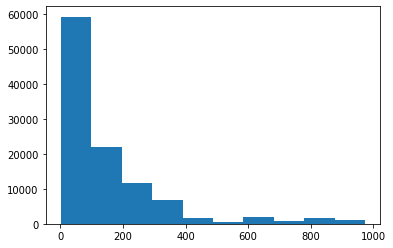

In [ ]:
fig = plt.figure()
plt.hist(Wiki_votes["Votes"].tolist())
plt.show()

We can now see the distribution of users per their number of votes, above. The selection of the subgraphs can then be made by taking three different subgraphs that have a big distinction and still are not to small. 

Here vote between 100 and 200 will represent the low number of votes, the user how has votes between 400 and 500 votes will represent the middle one, and votes between 800 and 900 will represent the high number of votes. In the code below this subgraph is created.  

In [ ]:
mask_low_votes = (Wiki_votes["Votes"] >= 100) & (Wiki_votes["Votes"] <= 200)
mask_middle_votes = (Wiki_votes["Votes"] >= 400) & (Wiki_votes["Votes"] <= 500)
mask_high_votes = (Wiki_votes["Votes"] >= 800) & (Wiki_votes["Votes"] <= 900)

wiki_low_sentiment = Wiki_votes.loc[mask_low_votes]
wiki_middle_sentiment = Wiki_votes.loc[mask_middle_votes]
wiki_high_sentiment = Wiki_votes.loc[mask_high_votes]

In [ ]:
wikipedia_low_graph = nx.from_pandas_edgelist(wiki_low_sentiment,"FromNodeId","ToNodeId",edge_attr="Sign",create_using=nx.DiGraph)
wikipedia_middle_graph = nx.from_pandas_edgelist(wiki_middle_sentiment,"FromNodeId","ToNodeId",edge_attr="Sign",create_using=nx.DiGraph)
wikipedia_high_graph = nx.from_pandas_edgelist(wiki_high_sentiment,"FromNodeId","ToNodeId",edge_attr="Sign",create_using=nx.DiGraph)

wikipedia_low_table1,wikipedia_low_table2 = graph_properties(wikipedia_low_graph)
wikipedia_middle_table1,wikipedia_middle_table2 = graph_properties(wikipedia_middle_graph)
wikipedia_high_table1,wikipedia_high_table2 = graph_properties(wikipedia_high_graph)

/usr/local/lib/python3.6/dist-packages/networkx/algorithms/assortativity/correlation.py:287: RuntimeWarning: invalid value encountered in double_scalars
  return (xy * (M - ab)).sum() / numpy.sqrt(vara * varb)


In [ ]:
wikipedia_low_table1

,Average,Max,Min
Degree,19.001334,208.000000,1.000000
Closeness,0.025550,0.043724,0.000000
Local clustering coefficient,0.159898,1.000000,0.000000
Centrality,0.008453,0.092527,0.000445


In [ ]:
wikipedia_middle_table1

,Average,Max,Min
Degree,3.488411,473.000000,1.000000
Closeness,0.001653,0.004143,0.000000
Local clustering coefficient,0.243319,1.000000,0.000000
Centrality,0.002890,0.391881,0.000829


In [ ]:
wikipedia_high_table1

,Average,Max,Min
Degree,1.997416,773.000000,1.000000
Closeness,0.001292,0.001294,0.000000
Local clustering coefficient,0.000000,0.000000,0.000000
Centrality,0.002584,1.000000,0.001294


-----

In [ ]:
wikipedia_low_table2

,
Global clustering coefficient,0.018022
Assortativity degree,-0.046083


In [ ]:
wikipedia_middle_table2

,
Global clustering coefficient,0.001198
Assortativity degree,-0.070573


In [ ]:
wikipedia_high_table2

,
Global clustering coefficient,0.0
Assortativity degree,NaN


-----

The result from the subgraph show a clear tendency in increasing number of average degree and closeness between the users with lower number votes, thus it does not seem to exist a tighter link between the users with a similar number of votes. As earlier explained the number of votes can be seen as a measurement of trustworthiness. The properties in the subgraphs show that the more trustworthy a user is the less expected is the user to have a connection to similar users, in terms of a number of votes. Of course, this comes with the consideration that the number of a user is considerably larger for a graph with a low number of votes, thus it is possible to have a total higher number of edges. At the same does the measurement of the subgraph, between the highest number of votes by a user, have the max degree by one user at 773 compared to 208 for the subgraph with the lowest votes. That shows that in fact the subgraph with the lowest number of votes has the node with the highest degree.

#### Conclusion on weights 

By grouping the Reddit data set by sentiment score the result was that the middle one had the fewest connections. If the sentiment score is in the middle the post neither contains strongly positive or negative opinions. This in contrast with a post that had a low or high sentiment score which was more strongly connected to posts with the same score. This indicates that similar posts are stronger linked to each other. To be sure of this effect further analysis had to be done. When grouping the Wikipedia, by the number of votes per user, it was shown that users that had a done a lower amount of votes were more strongly linked to each other, compared to the other subgraphs. Users with the highest amount of votes were least strongly linked with each other. This is not in the line with the result for the Reddit grouping by sentiment score, but it is not necessarily a contradiction of the result as it a different type of grouping. By this, we can conclude that the strength of subgraphs of the network can be highly affected by how similar the nodes are. Furthermore, this can be depending on how significant and extreme the similarity is. Post that was neither positive nor negative, thus neutral, did not have a strong connection. In the same way, the users that belong to the category with the lowest number of made votes had instead stronger connection.